## GUI test

In [44]:
import tkinter as tk
from tkinter import ttk
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import threading
import time
from collections import deque

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

# 导入真实的 Agilent_86142B 驱动
from KeckLFC.Hardware.Agilent_86142B import Agilent_86142B

# ------------------------------------------------------------
# Dummy Lfc service for testing without ICE
# ------------------------------------------------------------
class DummyLfcService:
    def __init__(self):
        # 模拟关键词的初始值
        self.mkl = {
            "LFC_TEMP_MONITOR": "1",       # 1 = Normal
            "LFC_RFOSCI_MONITOR": "0",     # 0 = normal
            "AMPLIFIER_MONITOR": "0",      # 0 = normal
            "INTERLOCK_MONITOR": "0",      # 0 = normal
            "REPETITION_RATE": "16"        # 单位 GHz，示例为 16GHz
        }
        self.current_status = "OFF"  # 初始状态

    def __getitem__(self, key):
        return self.mkl.get(key, "0")

    def __setitem__(self, key, value):
        self.mkl[key] = value

    def check_status(self):
        """
        返回当前 LFC 状态：OFF/ON/STANDBY/FULL COMB。
        """
        return self.current_status

    # 各按钮对应的实际操作——只更新 current_status
    def do_lfc_off(self):
        self.current_status = "OFF"

    def do_lfc_on(self):
        self.current_status = "ON"

    def do_lfc_standby(self):
        self.current_status = "STANDBY"

    def do_lfc_full_comb(self):
        self.current_status = "FULL COMB"

# ------------------------------------------------------------
# LfcMonitorGUI 类
# ------------------------------------------------------------
class LfcMonitorGUI:
    def __init__(self, root, lfc_service):
        self.root = root
        self.lfc = lfc_service
        self.pending_action = None
        self.first_update_done = False

        # 用 deque 存放最多10行消息
        self.log_lines = deque(maxlen=10)

        root.title("LFC STATUS and CONTROL (Demo)")
        root.geometry("1280x900")
        root.protocol("WM_DELETE_WINDOW", self.on_close)

        # 整体布局
        frame = ttk.Frame(root, padding=10)
        frame.grid(row=0, column=0, sticky="nsew")
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)
        frame.columnconfigure(2, weight=1)

        # -------- 左侧：控制按钮 --------
        btn_frame = ttk.LabelFrame(frame, text="Device control", padding=8)
        btn_frame.grid(row=0, column=0, sticky="nw", padx=(0,10))
        self.control_buttons = []
        btn_texts = ["LFC OFF", "LFC ON", "LFC STANDBY", "LFC FULL COMB"]
        actions = ["LFC_OFF", "LFC_ON", "LFC_STANDBY", "LFC_FULL_COMB"]
        for i, action in enumerate(actions):
            btn = ttk.Button(
                btn_frame,
                text=btn_texts[i],
                command=lambda act=action: self.request_action(act),
                state="disabled"  # 首次禁用，等待第一次刷新后启用
            )
            btn.grid(row=i, column=0, pady=(0,5), sticky="ew")
            self.control_buttons.append(btn)
        for i in range(4, 8):
            ttk.Button(btn_frame, text="", state="disabled").grid(
                row=i, column=0, pady=(0,5), sticky="ew"
            )

        # -------- 中央：状态监测 --------
        status_frame = ttk.LabelFrame(frame, text="Status monitor", padding=8)
        status_frame.grid(row=0, column=1, sticky="nsew")
        status_frame.columnconfigure(1, weight=1)

        # 0) 当前状态
        ttk.Label(status_frame, text="Current Status：").grid(
            row=0, column=0, sticky="w", pady=(0,10)
        )
        self.current_status_label = ttk.Label(status_frame, text="--")
        self.current_status_label.grid(row=0, column=1, sticky="w", pady=(0,10))

        # 指示灯
        self.status_items = [
            ("LFC_TEMP_MONITOR", "TEMP monitor"),
            ("LFC_RFOSCI_MONITOR", "RF Oscillator"),
            ("AMPLIFIER_MONITOR", "Amplifier Monitor"),
            ("INTERLOCK_MONITOR", "Interlock Monitor"),
        ]
        self.indicator_ids = {}
        for idx, (kw, label_text) in enumerate(self.status_items, start=1):
            ttk.Label(status_frame, text=label_text + "：").grid(
                row=idx, column=0, sticky="w", pady=5
            )
            c = tk.Canvas(status_frame, width=20, height=20, highlightthickness=0)
            oval = c.create_oval(2, 2, 18, 18, fill="gray")
            c.grid(row=idx, column=1, sticky="w", padx=5)
            self.indicator_ids[kw] = (c, oval)

        # Repetition Rate
        idx = len(self.status_items) + 1
        ttk.Label(status_frame, text="Repetition Rate (GHz)：").grid(
            row=idx, column=0, sticky="w", pady=10
        )
        self.rr_label = ttk.Label(status_frame, text="-- GHz")
        self.rr_label.grid(row=idx, column=1, sticky="w", padx=5, pady=10)

        # Last Update（红色字体）
        idx += 1
        ttk.Label(status_frame, text="Last Update：").grid(
            row=idx, column=0, sticky="w", pady=5
        )
        self.last_update_label = tk.Label(
            status_frame, text="--:--:--", fg="red"
        )
        self.last_update_label.grid(
            row=idx, column=1, sticky="w", padx=5, pady=5
        )

        # MiniComb Trace
        idx += 1
        ttk.Label(status_frame, text="MiniComb Trace：").grid(
            row=idx, column=0, sticky="nw", pady=5
        )
        self.trace_frame = ttk.Frame(status_frame)
        self.trace_frame.grid(
            row=idx, column=1, sticky="nsew", padx=5, pady=5
        )
        status_frame.rowconfigure(idx, weight=1)
        status_frame.columnconfigure(1, weight=1)

        # -------- 右侧：确认区（始终可见） --------
        confirm_frame = ttk.LabelFrame(frame, text="Confirm", padding=8)
        confirm_frame.grid(row=0, column=2, sticky="ne", padx=(10,0))
        self.confirm_frame = confirm_frame

        # 确认文本
        self.confirm_label = ttk.Label(confirm_frame, text="")
        self.confirm_label.grid(row=0, column=0, columnspan=2, pady=(0,5))

        # Yes / No 按钮
        self.yes_button = ttk.Button(
            confirm_frame, text="Yes", command=self.execute_action
        )
        self.yes_button.grid(row=1, column=0, padx=(0,5))
        self.yes_button.configure(style="Green.TButton")

        self.no_button = ttk.Button(
            confirm_frame, text="No", command=self.cancel_action
        )
        self.no_button.grid(row=1, column=1)
        self.no_button.configure(style="Red.TButton")

        # 交互框：使用 Listbox 容纳多行日志
        self.log_listbox = tk.Listbox(
            confirm_frame,
            height=20,
            width=60
        )
        self.log_listbox.grid(row=2, column=0, columnspan=2, pady=(10,0))

        # 定义按钮颜色样式
        style = ttk.Style()
        style.configure("Green.TButton", foreground="green")
        style.configure("Red.TButton", foreground="red")

        # 初始化：禁用所有控制按钮 和 Yes/No
        for btn in self.control_buttons:
            btn.config(state="disabled")
        self.yes_button.config(state="disabled")
        self.no_button.config(state="disabled")

        # 周期性刷新
        self.poll_interval = 10000
        self.root.after(self.poll_interval, self.update_indicators)

    def request_action(self, action_name: str):
        """
        用户点击某个控制按钮后，设定 pending_action 并启用 Yes/No。
        """
        # 禁用所有控制按钮
        for btn in self.control_buttons:
            btn.config(state="disabled")

        self.pending_action = action_name
        self.confirm_label.config(text=f"Confirm {action_name}?")
        self.yes_button.config(state="normal")
        self.no_button.config(state="normal")

    def execute_action(self):
        """
        用户在确认区点击 Yes：启动后台执行，并记录“开始执行”日志。
        """
        action = self.pending_action
        # 记录 “xxx 函数执行” + 时间
        start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self._append_log(f"{action} function started：{start_time}")

        # 禁用 Yes/No，防止重复点击
        self.yes_button.config(state="disabled")
        self.no_button.config(state="disabled")

        # 后台线程执行耗时任务
        threading.Thread(
            target=self._run_action_thread, args=(action,), daemon=True
        ).start()

    def _run_action_thread(self, action_name):
        """
        后台执行操作：先调用 DummyLfcService 对应方法，再记录“执行完毕”日志。
        """
        print(f"[Demo GUI] Executing {action_name}...")
        # 根据 action_name 调用 DummyLfcService 对应方法
        if action_name == "LFC_OFF":
            self.lfc.do_lfc_off()
        elif action_name == "LFC_ON":
            self.lfc.do_lfc_on()
        elif action_name == "LFC_STANDBY":
            self.lfc.do_lfc_standby()
        elif action_name == "LFC_FULL_COMB":
            self.lfc.do_lfc_full_comb()

        # 模拟耗时任务（5秒）
        time.sleep(5)
        print(f"[Demo GUI] {action_name} completed.")

        # 在主线程更新结果
        self.root.after(0, lambda: self._action_complete(action_name))

    def _action_complete(self, action_name):
        """
        在 GUI 线程中更新：
         - message_listbox 增加“xxx 函数执行完毕” + 时间
         - 重新启用控制按钮
        """
        finish_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self._append_log(f"{action_name} function completed：{finish_time}")

        # 重新启用所有控制按钮
        for btn in self.control_buttons:
            btn.config(state="normal")

        # 清除 pending_action
        self.pending_action = None

    def cancel_action(self):
        """
        用户点击 No：取消操作，恢复控制按钮，禁用 Yes/No。
        日志保留不变。
        """
        self.pending_action = None
        self.confirm_label.config(text="")
        for btn in self.control_buttons:
            btn.config(state="normal")
        self.yes_button.config(state="disabled")
        self.no_button.config(state="disabled")

    def _append_log(self, text: str):
        """
        在日志 Listbox 中添加一行。最多保留 10 行，超出时自动删除顶部。
        """
        # 如果已达 10 行，移除最顶部的一行
        if len(self.log_listbox.get(0, tk.END)) >= 20:
            self.log_listbox.delete(0)
        self.log_listbox.insert(tk.END, text)
        # 自动滚到底部
        self.log_listbox.yview_moveto(1.0)

    def update_indicators(self):
        """
        周期性刷新：
         0) 检查 current_status（from lfc.check_status），除非有 pending_action
         1) 更新指示灯
         2) 更新 Repetition Rate
         3) 更新 Last Update
         4) 更新 MiniComb Trace
         5) 首次刷新后启用所有控制按钮
        """
        # 0) 如果没有 pending_action，才用 lfc.check_status 更新 current_status
        if self.pending_action is None:
            try:
                status_str = self.lfc.check_status()
            except:
                status_str = "--"
            self.current_status_label.config(text=status_str)

        # 1) 更新指示灯
        for kw, _ in self.status_items:
            canvas, oval_id = self.indicator_ids[kw]
            raw = self.lfc.mkl.get(kw, "0")
            try:
                val = int(raw)
            except:
                val = None

            if kw == "LFC_TEMP_MONITOR":
                color = "green" if val == 1 else "red"
            elif kw == "LFC_RFOSCI_MONITOR":
                color = "green" if val == 0 else "red"
            elif kw == "AMPLIFIER_MONITOR":
                color = "green" if val == 0 else "red"
            elif kw == "INTERLOCK_MONITOR":
                color = "green" if val == 0 else "red"
            else:
                color = "gray"

            canvas.itemconfig(oval_id, fill=color)

        # 2) 更新 Repetition Rate
        rr_value = self.lfc.mkl.get("REPETITION_RATE", "--")
        try:
            rr_text = f"{int(rr_value)} GHz"
        except:
            rr_text = "--"
        self.rr_label.config(text=rr_text)

        # 3) 更新 Last Update
        now_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        self.last_update_label.config(text=now_str)

        # 4) 更新 MiniComb Trace
        for widget in self.trace_frame.winfo_children():
            widget.destroy()
        try:
            osa = Agilent_86142B()
            osa.connect()
            osa.Run()
            wl, intensity = osa.get_trace('A', plot=False)
            osa.disconnect()

            fig = plt.Figure(figsize=(5,4), dpi=100)
            ax = fig.add_subplot(111)
            ax.plot(wl, intensity)
            ax.set_xlabel('Wavelength (nm)')
            ax.set_ylabel('Intensity (dBm)')
            ax.set_ylim(-75, 0)
            fig.tight_layout()

            canvas_fig = FigureCanvasTkAgg(fig, master=self.trace_frame)
            canvas_fig_widget = canvas_fig.get_tk_widget()
            canvas_fig_widget.pack(fill='both', expand=True)

        except Exception as e:
            print(f"[Demo GUI] OSA trace failed: {e}")
            ttk.Label(self.trace_frame, text="Trace unavailable").pack()

        # 5) 首次刷新后启用所有控制按钮
        if not self.first_update_done:
            for btn in self.control_buttons:
                btn.config(state="normal")
            self.first_update_done = True

        self.root.after(self.poll_interval, self.update_indicators)

    def on_close(self):
        self.root.destroy()




In [45]:
# Run the GUI for demo
root = tk.Tk()
dummy_service = DummyLfcService()
app = LfcMonitorGUI(root, dummy_service)
root.mainloop()

2025-06-01 21:31:10.425 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:31:10.425 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:31:11.278 | INFO     | Agilent 86142B | Device.py:disconnect:100
Agilent 86142B disconnected
2025-06-01 21:31:21.330 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:31:21.347 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:31:22.314 | INFO     | Agilent 86142B | Device.py:disconnect:100
Agilent 86142B disconnected


[Demo GUI] Executing LFC_ON...
[Demo GUI] LFC_ON completed.


2025-06-01 21:31:32.368 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:31:32.368 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:31:33.289 | INFO     | Agilent 86142B | Device.py:disconnect:100
Agilent 86142B disconnected


[Demo GUI] Executing LFC_FULL_COMB...
[Demo GUI] LFC_FULL_COMB completed.


2025-06-01 21:31:43.343 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:31:43.347 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:31:44.228 | INFO     | Agilent 86142B | Device.py:disconnect:100
Agilent 86142B disconnected
2025-06-01 21:31:54.277 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:31:54.277 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:31:55.265 | INFO     | Agilent 86142B | Device.py:disconnect:100
Agilent 86142B disconnected
2025-06-01 21:32:05.307 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected
2025-06-01 21:32:05.307 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.
2025-06-01 21:32:06.152 | INFO     | Agilent 86142B | Device.py:disconnect:100

In [41]:
from KeckLFC.Hardware.Agilent_86142B import Agilent_86142B

osa = Agilent_86142B()
osa.connect()



2025-06-01 21:26:36.831 | INFO     | Agilent 86142B | Device.py:connect:88
Agilent 86142B connected


1

In [42]:
osa.wlstart=1553
osa.wlstop=1567
osa.reflevel=-40


2025-06-01 21:26:41.179 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstart:118
Agilent 86142B: Scan start wavelength set to 1553.00 nm.
2025-06-01 21:26:42.143 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstop:127
Agilent 86142B: Scan stop wavelength set to 1567.00 nm.
2025-06-01 21:26:42.833 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.


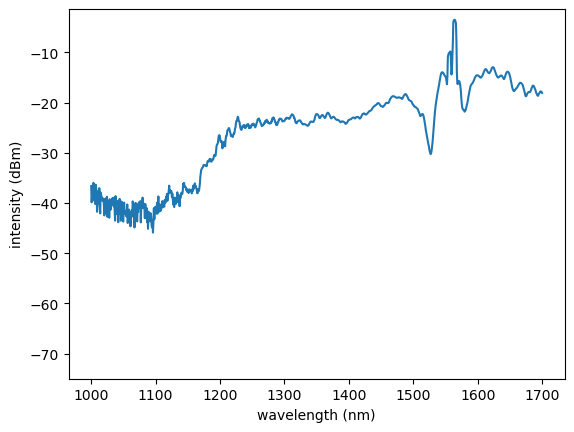

2025-05-17 11:15:25.950 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.
2025-05-17 11:15:25.960 | INFO     | Agilent 86142B | Agilent_86142B.py:save_trace:397
Agilent 86142B: Trace A data is saved to C:\Users\KeckLFC\Desktop\hispec\3m_hnlf_for1550_3.63w.mat
2025-05-17 11:15:25.970 | INFO     | Agilent 86142B | Agilent_86142B.py:save_trace:412
Agilent 86142B: Trace A data is saved to C:\Users\KeckLFC\Desktop\hispec\3m_hnlf_for1550_3.63w.txt


In [423]:
filedir = r'C:\Users\KeckLFC\Desktop\hispec'
filename = r'\3m_hnlf_for1550_3.63w'
filr = filedir + filename
osa.save_trace('a', filr)

In [2]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [4]:
input_power=2
if (input_power>10) or (input_power<1):
    print('wrong')

In [66]:
osa.disconnect()

2024-07-17 12:20:58.978 | INFO     | Agilent 86142B | Device.py:disconnect:90
Agilent 86142B disconnected


1

In [1]:
!dir

 Volume in drive C has no label.
 Volume Serial Number is BC2E-EE77

 Directory of c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Notebooks

07/17/2024  08:30 PM    <DIR>          .
07/18/2024  07:02 PM    <DIR>          ..
11/03/2023  12:35 PM            52,871 AndoOSA_test.ipynb
11/03/2023  12:35 PM        11,504,127 Compression_Stage_Test.ipynb
05/27/2024  10:18 AM            47,665 email_test.ipynb
11/03/2023  12:35 PM         3,929,808 Filter-Cavity-Locking-Test.ipynb
03/05/2024  10:43 AM         2,418,222 July_Commission.ipynb
11/03/2023  12:35 PM           451,323 Jun_Commission.ipynb
11/03/2023  12:35 PM           434,279 KeckLFC_class_test.ipynb
02/07/2024  02:07 PM               258 KTL_test.py
11/03/2023  12:35 PM            43,815 LFI-3751_test.ipynb
06/23/2024  06:52 PM           660,357 Minicomb_test_Feb.ipynb
07/17/2024  08:30 PM           914,032 new_laptop_test.ipynb
11/03/2023  12:35 PM             7,469 OZvoaTest.ipynb
11/03/2023  12:35 PM             1,826 pendulum_test.ipyn

In [3]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [2]:
cd KeckLFC-main

[WinError 2] The system cannot find the file specified: 'KeckLFC-main'
c:\Users\KeckLFC\KeckLFC-main\KeckLFC\Notebooks


2025-06-01 20:02:02.546 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.


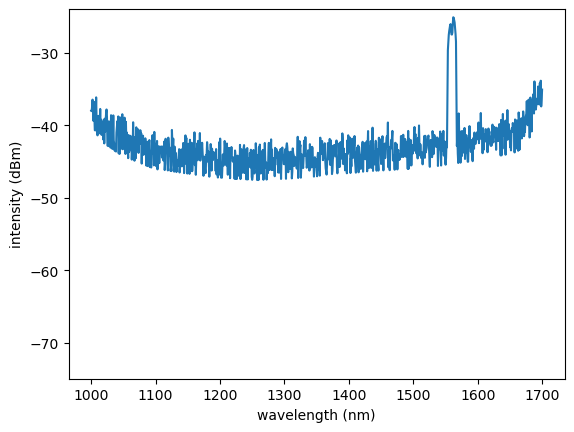

2025-06-01 20:02:03.567 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1000. , 1000.7, 1001.4, ..., 1698.6, 1699.3, 1700. ], dtype=float32),
 array([-37.971344, -38.028084, -37.366047, ..., -37.370075, -36.335037,
        -35.043   ], dtype=float32))

In [18]:
# osa.wlstop =1567
osa.Run()
osa.get_trace('a')

In [77]:
osa.set_reflevel(-40)

2024-02-22 14:18:32.631 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.


In [70]:
osa.set_resolution(0.05)
osa.get_resolution()

2024-07-17 12:23:41.140 | INFO     | Agilent 86142B | Agilent_86142B.py:set_resolution:160
Agilent 86142B: Resolution set to 0.06 nm.


0.06

In [45]:
osa.write(f'SENS:WAV:STAR {1550:.2f}nm')
osa.get_wlcenter()

1625.0

In [7]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic27 = AmonicsEDFA(addr=f'ASRL{6}::INSTR', name='Amonics EDFA 27 dBm')
amonic27.connect()
amonic27.printStatus()


2025-05-13 11:44:18.041 | INFO     | Amonics EDFA 27 dBm | Device.py:connect:78
Amonics EDFA 27 dBm connected
2025-05-13 11:44:18.354 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 24.84°C
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: ON
|		 Input Power: 5.768435 mW
|		 Output Power: 451.3953 mW
|		 Internal PD Power: 326.226 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 24.84°C\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bON\x1b\n|\t\t Input Power: 5.768435 mW\n|\t\t Output Power: 451.3953 mW\n|\t\t Internal PD Power: 326.226 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [41]:
amonic27._setChMode('apc')

2024-07-17 12:12:49.055 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChMode:297
Amonics EDFA 27 dBm: CH1 mode set as apc


In [42]:
amonic27.accCh1Cur='450mw'

2024-07-17 12:13:06.456 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setIorP:229
Amonics EDFA 27 dBm: setted APC mode CH1 current as 450.0 mW.


In [6]:
amonic27.accCh1Status = 1
amonic27.activation = 1

2024-11-20 12:24:27.670 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 27 dBm: ......waiting APC CH1 status set to ON, now OFF
2024-11-20 12:24:27.717 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 27 dBm: setted APC CH1 status as ON, finished in 0.091 seconds
2024-11-20 12:24:27.755 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:185
Amonics EDFA 27 dBm: ACTIVATING LASER OUTPUT, MAKE SURE SEED INPUT POWER IS APPROPRIATE TO AVOID DAMAGE
2024-11-20 12:24:27.780 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:192
Amonics EDFA 27 dBm: ......waiting Activation status set to ON, now OFF
2024-11-20 12:24:27.831 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:195
Amonics EDFA 27 dBm: setted Activation status as ON, finished in 0.075 seconds


In [8]:
amonic27.printStatus()

2024-11-20 12:24:36.363 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 22.56°C
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: ON
|		 Input Power: 5.301677 mW
|		 Output Power: 447.3162 mW
|		 Internal PD Power: 328.4008 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 22.56°C\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bON\x1b\n|\t\t Input Power: 5.301677 mW\n|\t\t Output Power: 447.3162 mW\n|\t\t Internal PD Power: 328.4008 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [44]:
rfoscPS.printStatus()

2024-07-17 12:13:23.962 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CV Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=14.998V, IOUT=0.431A.
|		 Output power: 6.464W.
|	 CHANNEL3: CV Mode.
|		 VSET=0.100V, ISET=1.000A.
|		 VOUT=0.099V, IOUT=0.001A.
|		 Output power: 0.000W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------



'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CV Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=14.998V, IOUT=0.431A.\n|\t\t Output power: 6.464W.\n|\t CHANNEL3: CV Mode.\n|\t\t VSET=0.100V, ISET=1.000A.\n|\t\t VOUT=0.099V, IOUT=0.001A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [17]:
from KeckLFC.Hardware.InstekGPD_4303S import InstekGPD_4303S
rfoscPS = InstekGPD_4303S(addr='ASRL13::INSTR', name='RF oscilator PS, CH2 15V, CH3 1V')
rfoscPS.connect()
rfoscPS.printStatus()

2025-05-13 12:42:06.904 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | Device.py:connect:78
RF oscilator PS, CH2 15V, CH3 1V connected
2025-05-13 12:42:19.853 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CV Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=14.997V, IOUT=0.390A.
|		 Output power: 5.849W.
|	 CHANNEL3: CV Mode.
|		 VSET=0.750V, ISET=1.000A.
|		 VOUT=0.750V, IOUT=0.002A.
|		 Output power: 0.001W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, I

'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CV Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=14.997V, IOUT=0.390A.\n|\t\t Output power: 5.849W.\n|\t CHANNEL3: CV Mode.\n|\t\t VSET=0.750V, ISET=1.000A.\n|\t\t VOUT=0.750V, IOUT=0.002A.\n|\t\t Output power: 0.001W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.001A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [16]:
rfoscPS.printStatus()

2024-11-20 12:25:52.339 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:printStatus:200
-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------
|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------
|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CH1: master, CH2: slave, mode UNRECOGNIZED?.
|	 CHANNEL1: CC Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
|	 CHANNEL2: CV Mode.
|		 VSET=15.000V, ISET=3.000A.
|		 VOUT=14.997V, IOUT=0.609A.
|		 Output power: 9.148W.
|	 CHANNEL3: CV Mode.
|		 VSET=0.700V, ISET=1.000A.
|		 VOUT=0.700V, IOUT=0.001A.
|		 Output power: 0.001W.
|	 CHANNEL4: CV Mode.
|		 VSET=0.000V, ISET=0.000A.
|		 VOUT=0.000V, IOUT=0.000A.
|		 Output power: 0.000W.
--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------



'-------------------------RF oscilator PS, CH2 15V, CH3 1V------------------------\n|----------------Instek DC Power Supply GPD-4303S Status Summary-----------------\n|--------------------Model: GPD-4303S, Serial No.SN:EV884423---------------------\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CH1: master, CH2: slave, mode UNRECOGNIZED?.\n|\t CHANNEL1: CC Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n|\t CHANNEL2: CV Mode.\n|\t\t VSET=15.000V, ISET=3.000A.\n|\t\t VOUT=14.997V, IOUT=0.609A.\n|\t\t Output power: 9.148W.\n|\t CHANNEL3: CV Mode.\n|\t\t VSET=0.700V, ISET=1.000A.\n|\t\t VOUT=0.700V, IOUT=0.001A.\n|\t\t Output power: 0.001W.\n|\t CHANNEL4: CV Mode.\n|\t\t VSET=0.000V, ISET=0.000A.\n|\t\t VOUT=0.000V, IOUT=0.000A.\n|\t\t Output power: 0.000W.\n--------------Instek DC Power Supply GPD-4303S Status Summary Ends--------------\n'

In [15]:
rfoscPS.activation = 1

2024-11-20 12:25:36.492 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:activation:44
Instek GPD-4303S DCSupply: Output activation is turned ON.


In [46]:
from KeckLFC.Hardware.InstekGppDCSupply import InstekGppDCSupply

rfampPS = InstekGppDCSupply(addr=f'ASRL{24}::INSTR', name='RF amplifier PS 30V 4A')
rfampPS.connect()
rfampPS.printStatus()


2024-12-06 07:12:27.557 | INFO     | RF amplifier PS 30V 4A | Device.py:connect:78
RF amplifier PS 30V 4A connected
2024-12-06 07:12:27.702 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:printStatus:56
------------------------------RF amplifier PS 30V 4A-----------------------------
|-------------------Instek GPP DC Power Supply Status Summary--------------------
|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------
|	------------Channel Summary-------------
|	 CHANNEL1: Activation ON.
|		 VSET=30.000V, ISET=4.200A.
|		 VOUT=29.990V, IOUT=3.963A.
|		 Output power: 118.862W.
|		 ---Over Voltage/Current Protection Status:---
|		 OVP Status: OFF	 OCP Status: OFF 
|		 OVP Level : 35.0 V	 OCP Level : 7.0 A
-----------------Instek GPP DC Power Supply Status Summary Ends-----------------



'------------------------------RF amplifier PS 30V 4A-----------------------------\n|-------------------Instek GPP DC Power Supply Status Summary--------------------\n|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------\n|\t------------Channel Summary-------------\n|\t CHANNEL1: Activation \x1bON\x1b.\n|\t\t VSET=30.000V, ISET=4.200A.\n|\t\t VOUT=29.990V, IOUT=3.963A.\n|\t\t Output power: 118.862W.\n|\t\t ---Over Voltage/Current Protection Status:---\n|\t\t OVP Status: OFF\t OCP Status: OFF \n|\t\t OVP Level : 35.0 V\t OCP Level : 7.0 A\n-----------------Instek GPP DC Power Supply Status Summary Ends-----------------\n'

In [28]:
rfampPS.Vset1=30
rfampPS.Iset1=4.2

2024-07-17 12:09:11.139 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setVSET:284
RF amplifier PS 30V 4A: VSET channel 1 set to 30.000V
2024-07-17 12:09:11.173 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setISET:260
RF amplifier PS 30V 4A: ISET channel 1 set to 4.200A


In [13]:
rfampPS.activation1 = 1


2024-11-20 12:25:24.766 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:_setOutputStatus:237
RF amplifier PS 30V 4A: channel 1 output is turned ON


In [17]:
rfampPS.printStatus()

2024-11-20 12:26:01.815 | INFO     | RF amplifier PS 30V 4A | InstekGppDCSupply.py:printStatus:56
------------------------------RF amplifier PS 30V 4A-----------------------------
|-------------------Instek GPP DC Power Supply Status Summary--------------------
|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------
|	------------Channel Summary-------------
|	 CHANNEL1: Activation ON.
|		 VSET=30.000V, ISET=4.200A.
|		 VOUT=29.994V, IOUT=4.026A.
|		 Output power: 120.741W.
|		 ---Over Voltage/Current Protection Status:---
|		 OVP Status: OFF	 OCP Status: OFF 
|		 OVP Level : 35.0 V	 OCP Level : 7.0 A
-----------------Instek GPP DC Power Supply Status Summary Ends-----------------



'------------------------------RF amplifier PS 30V 4A-----------------------------\n|-------------------Instek GPP DC Power Supply Status Summary--------------------\n|--------------------Model: GPP-1326, Serial No.SN:GET842785---------------------\n|\t------------Channel Summary-------------\n|\t CHANNEL1: Activation \x1bON\x1b.\n|\t\t VSET=30.000V, ISET=4.200A.\n|\t\t VOUT=29.994V, IOUT=4.026A.\n|\t\t Output power: 120.741W.\n|\t\t ---Over Voltage/Current Protection Status:---\n|\t\t OVP Status: OFF\t OCP Status: OFF \n|\t\t OVP Level : 35.0 V\t OCP Level : 7.0 A\n-----------------Instek GPP DC Power Supply Status Summary Ends-----------------\n'

In [90]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic27 = AmonicsEDFA(addr=f'ASRL{6}::INSTR', name='Amonics EDFA 27 dBm')
amonic27.connect()
amonic27.printStatus()

2025-04-07 12:55:01.784 | INFO     | Amonics EDFA 27 dBm | Device.py:connect:78
Amonics EDFA 27 dBm connected
2025-04-07 12:55:02.090 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 28.00°C
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: ON
|		 Input Power: 6.311691 mW
|		 Output Power: 451.3953 mW
|		 Internal PD Power: 324.8187 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 28.00°C\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bON\x1b\n|\t\t Input Power: 6.311691 mW\n|\t\t Output Power: 451.3953 mW\n|\t\t Internal PD Power: 324.8187 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [5]:
amonic27.accCh1Cur = '450mA'
amonic27.accCh1Status = 1
amonic27.activation = 1


2025-04-07 13:01:48.665 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setIorP:229
Amonics EDFA 27 dBm: setted APC mode CH1 current as 450.0 mW.
2025-04-07 13:01:48.713 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 27 dBm: ......waiting APC CH1 status set to ON, now OFF
2025-04-07 13:01:48.759 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 27 dBm: setted APC CH1 status as ON, finished in 0.079 seconds
2025-04-07 13:01:48.784 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:185
Amonics EDFA 27 dBm: ACTIVATING LASER OUTPUT, MAKE SURE SEED INPUT POWER IS APPROPRIATE TO AVOID DAMAGE
2025-04-07 13:01:48.823 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:192
Amonics EDFA 27 dBm: ......waiting Activation status set to ON, now OFF
2025-04-07 13:01:48.873 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:activation:195
Amonics EDFA 27 dBm: setted Activation status as ON, finished in 0.080 seconds


In [92]:
amonic27.printStatus()

2025-04-07 12:55:24.685 | INFO     | Amonics EDFA 27 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 27 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 28.04°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: APC
|		 Set Pwr: 450.0 mW
|		 Status: OFF
|		 Input Power: 6.258659 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 27 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-27-R-FA, Serial No.21082531-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 28.04°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: APC\n|\t\t Set Pwr: 450.0 mW\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 6.258659 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [18]:
amonic27.inputPowerCh1

0.0

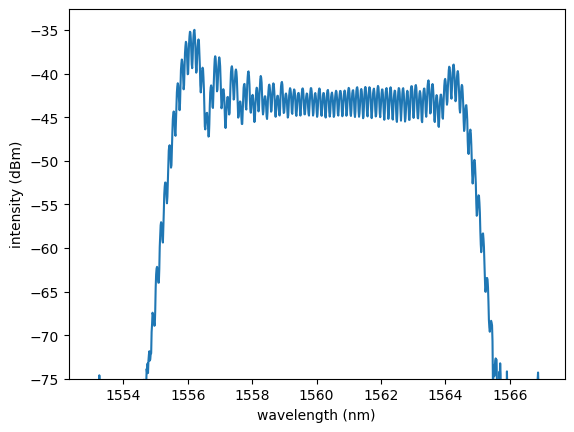

2024-12-06 07:36:23.306 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-76.501175, -77.26678 , -78.87862 , ..., -79.77604 , -78.86656 ,
        -77.83223 ], dtype=float32))

In [126]:
osa.get_trace('a')

In [64]:
import numpy as np
import time
import smtplib

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def score_eo_comb(osa):
    
    osa.wlstart=1553
    osa.wlstop=1567
    osa.reflevel=-40
    osa.set_resolution(0.06)
    
    osa.Single()
    time.sleep(0.5)
    x,y=osa.get_trace('a')

    
    #x1=x[np.where((x>start_wl) & (x<stop_wl))] 
    y1=y[np.where((x>1553) & (x<1567))]
    
    hight_shreshold=-50
    peaks,_ = find_peaks(y1, height=hight_shreshold, distance=2, width=0.02e-9)
    num_peaks = len(peaks)

    score=np.std(y1[peaks])*-1
    return score

In [56]:
osa.Single()

2024-07-21 14:08:37.686 | INFO     | Agilent 86142B | Agilent_86142B.py:Single:168
Agilent 86142B: Spectrum collection SINGLE run start.


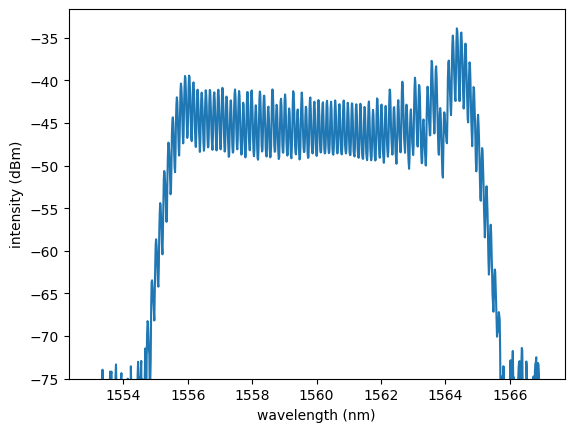

2024-07-22 08:41:12.327 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


In [22]:
x,y=osa.get_trace('a')

In [80]:
peaks,_ = find_peaks(y, height=-50, distance=2,width=0.02e-9)

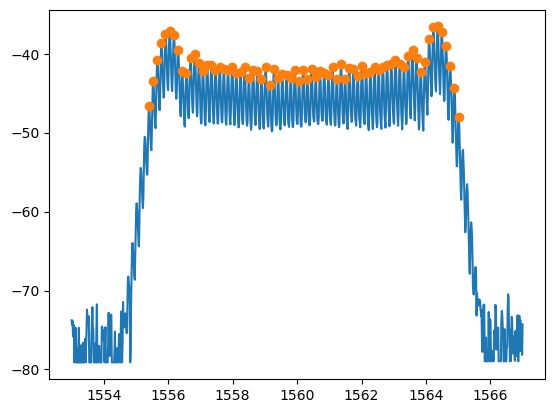

In [78]:
plt.plot(x,y)
plt.plot(x[peaks],y[peaks],'o')

2024-07-21 14:09:36.491 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstart:118
Agilent 86142B: Scan start wavelength set to 1553.00 nm.
2024-07-21 14:09:36.778 | INFO     | Agilent 86142B | Agilent_86142B.py:set_wlstop:127
Agilent 86142B: Scan stop wavelength set to 1567.00 nm.
2024-07-21 14:09:37.013 | INFO     | Agilent 86142B | Agilent_86142B.py:set_reflevel:109
Agilent 86142B: Reference level set to -40.0 dBm.
2024-07-21 14:09:37.264 | INFO     | Agilent 86142B | Agilent_86142B.py:set_resolution:160
Agilent 86142B: Resolution set to 0.06 nm.
2024-07-21 14:09:37.268 | INFO     | Agilent 86142B | Agilent_86142B.py:Single:168
Agilent 86142B: Spectrum collection SINGLE run start.


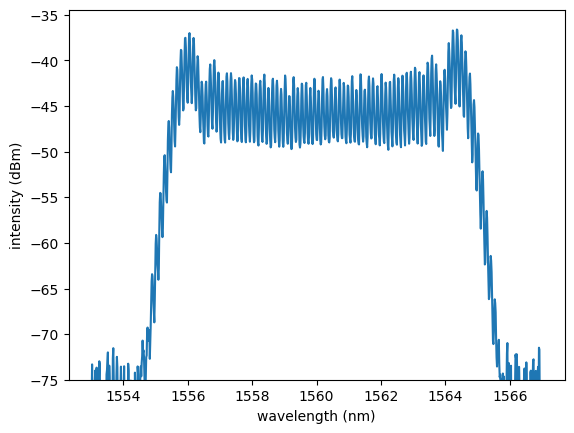

2024-07-21 14:09:38.445 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


-1.9384628534317017

In [62]:
score_eo_comb(osa)

2025-05-13 12:48:46.121 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:666
Minicomb Intensity Lock Servo: ....Manual output voltage Ramping.... Disable ranp by set self.manual_output_ramp=0. 
2025-05-13 12:48:46.333 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.600.
2025-05-13 12:48:46.541 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.600.
2025-05-13 12:48:46.541 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:681
Minicomb Intensity Lock Servo: ....Manual output voltage Ramp Finished. Disable ramp by set self.manual_output_ramp=0. 
2025-05-13 12:48:47.631 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:_setVSET:320
Instek GPD-4303S DCSupply: VSET channel 3 set to 0.800V
2025-05-13 12:48:48.633 | INFO 

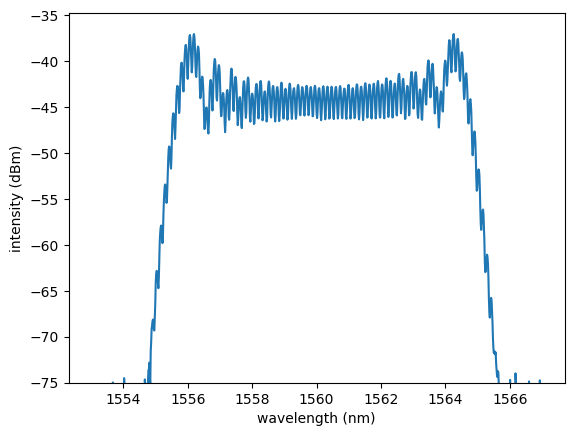

2025-05-13 12:48:49.507 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-82.494156, -82.494156, -77.12712 , ..., -81.3293  , -80.752426,
        -77.630104], dtype=float32))

In [42]:
import time
servo_IM.manual_output = -0.6
rfoscPS.Vset3=0.8
time.sleep(1)
osa.Run()
osa.get_trace('a')
# import time
# time.sleep(1)
# osa.get_trace('a')

In [11]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic23 = AmonicsEDFA(addr=f'ASRL{12}::INSTR', name='Amonics EDFA 23 dBm')
amonic23.connect()
amonic23.printStatus()

2025-04-07 13:03:31.316 | INFO     | Amonics EDFA 23 dBm | Device.py:connect:78
Amonics EDFA 23 dBm connected
2025-04-07 13:03:37.633 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 23 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 33.00°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 80.0 mA
|		 Status: OFF
|		 Input Power: 0.0 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 23 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 33.00°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 80.0 mA\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 0.0 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [12]:
amonic23.accCh1Cur = '80mA'
amonic23.accCh1Status = 1
amonic23.activation = 1

2025-04-07 13:03:45.920 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setIorP:227
Amonics EDFA 23 dBm: setted ACC mode CH1 current as 80.0 mA.
2025-04-07 13:03:47.945 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setChStatus:278
Amonics EDFA 23 dBm: ......waiting ACC CH1 status set to ON, now OFF
2025-04-07 13:03:48.001 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:_setChStatus:281
Amonics EDFA 23 dBm: setted ACC CH1 status as ON, finished in 0.086 seconds
2025-04-07 13:03:50.016 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:activation:185
Amonics EDFA 23 dBm: ACTIVATING LASER OUTPUT, MAKE SURE SEED INPUT POWER IS APPROPRIATE TO AVOID DAMAGE
2025-04-07 13:03:50.049 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:activation:192
Amonics EDFA 23 dBm: ......waiting Activation status set to ON, now OFF
2025-04-07 13:03:50.096 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:activation:195
Amonics EDFA 23 dBm: setted Activation status as ON, finished in 0.077 seconds


In [125]:
#time.sleep(3)
amonic23.printStatus()

2024-12-06 07:31:01.744 | INFO     | Amonics EDFA 23 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 23 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 32.85°C
|	Master Activation: ON
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 80.0 mA
|		 Status: ON
|		 Input Power: 2.238595 mW
|		 Output Power: 5.319314 mW
|		 Internal PD Power: 44.2117 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 23 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-23-R-FA, Serial No.22020702-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 32.85°C\n|\tMaster Activation: \x1bON\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 80.0 mA\n|\t\t Status: \x1bON\x1b\n|\t\t Input Power: 2.238595 mW\n|\t\t Output Power: 5.319314 mW\n|\t\t Internal PD Power: 44.2117 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [158]:
from KeckLFC.Hardware.Arduino_relay import Arduino_relay
arduino = Arduino_relay(addr="COM3")
# print(f'com={i}')
arduino.connect()
arduino.printStatus()


2025-05-15 14:12:25.929 | INFO     | Arduino Relay Circuit | Arduino_relay.py:connect:52
Arduino Relay Circuit connected
2025-05-15 14:12:26.332 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 1, trying again
2025-05-15 14:12:26.536 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 2, trying again
2025-05-15 14:12:26.738 | INFO     | Arduino Relay Circuit | Arduino_relay.py:query:90
Arduino Relay Circuit: Failed to query get, trial num 3, trying again
2025-05-15 14:12:27.142 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay is  STOPPING  amplifier, but will be  OK_to_Amplify  after reset_relay_latch.
|	 Relay Info: get
|		Now voltage is 564
|		Now voltage to judge (low) is 0
|		Now voltage to judge (high) is 1024
|		Low Threshold i

'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay is \x1b STOPPING \x1b amplifier, but will be \x1b OK_to_Amplify \x1b after reset_relay_latch.\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 564\r\n|\t\tNow voltage to judge (low) is 0\r\n|\t\tNow voltage to judge (high) is 1024\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [160]:
arduino.printStatus()

2025-05-15 14:12:37.839 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 585
|		Now voltage to judge (low) is 564
|		Now voltage to judge (high) is 586
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 585\r\n|\t\tNow voltage to judge (low) is 564\r\n|\t\tNow voltage to judge (high) is 586\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [159]:
arduino.reset_relay_latch()

'reset\r\r\nNow voltage is reset equal to input，and the voltage is:564'

In [11]:
message=arduino.get_YJ_info()
            
if message in ['YJState\r\r\nYJ shutter is UP, YJ is shutted.']:
                message = 0
if message in ['YJState\r\r\nYJ shutter is DOWN, YJ is passing.']:
                message = 1

print(message)

1


In [21]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [ ]:
arduino.disconnect()

2025-04-11 12:23:10.784 | INFO     | Arduino Relay Circuit | Arduino_relay.py:disconnect:65
Arduino Relay Circuit disconnected


1

In [ ]:
arduino.pass_YJ()

In [99]:
arduino.disconnect()

2025-05-13 17:30:46.004 | INFO     | Arduino Relay Circuit | Arduino_relay.py:disconnect:65
Arduino Relay Circuit disconnected


1

In [8]:
arduino.printStatus()

2025-04-07 13:09:29.949 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 587
|		Now voltage to judge (low) is 566
|		Now voltage to judge (high) is 588
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 587\r\n|\t\tNow voltage to judge (low) is 566\r\n|\t\tNow voltage to judge (high) is 588\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [153]:
arduino.get_YJ_info()

'YJState\r\r\nYJ shutter is UP, YJ is shutted.'

In [113]:
arduino.query("YJState")

'YJState\r\r\nYJ shutter is UP, YJ is shutted.'

In [152]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [13]:
arduino.query('GET')

'GET\r\r\nNow voltage is 4\r\nNow voltage to judge (low) is 0\r\nNow voltage to judge (high) is 1024\r\nLow Threshold is 317\r\nHigh Threshold is 690'

In [119]:
message=arduino.get_YJ_info()

if message in ['YJState\r\r\nYJ shutter is UP, YJ is shutted.']:
    message = 0
if message in ['YJState\r\r\nYJ shutter is DOWN, YJ is passing.']:
    message = 1
# fill in read functions
message

0

In [26]:
from KeckLFC.Hardware.PendulumCNT90 import PendulumCNT90
pendulem = PendulumCNT90()
pendulem.connect()

2024-07-21 13:31:18.734 | INFO     | Pendulum microwave counter | Device.py:connect:78
Pendulum microwave counter connected


1

In [28]:
freq=pendulem.measFreq('c')
freq-16e9

-140.56999969482422

In [12]:
arduino.get_relay_status()

'relay is STOPPING amplifier, because input power is too low'

In [24]:
arduino.reset_relay_latch()
arduino.printStatus()


2024-07-20 10:29:47.890 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 594
|		Now voltage to judge (low) is 592
|		Now voltage to judge (high) is 595
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 594\r\n|\t\tNow voltage to judge (low) is 592\r\n|\t\tNow voltage to judge (high) is 595\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [273]:
arduino.pass_YJ()

'YJPass\r\r\nYJ shutter is DOWN, YJ is passing.'

In [98]:
arduino.printStatus()

2025-05-13 17:30:33.374 | INFO     | Arduino Relay Circuit | Arduino_relay.py:printStatus:43
----------------------Arduino Relay Module Status Summary-----------------------
|	 Relay Status: relay sending  OK_to_Amplify  signal to amplifier
|	 Relay Info: get
|		Now voltage is 580
|		Now voltage to judge (low) is 552
|		Now voltage to judge (high) is 583
|		Low Threshold is 317
|		High Threshold is 690
|	 YJ Shutter State: YJState
|		YJ shutter is DOWN, YJ is  passing .
--------------------Arduino Relay Module Status Summary Ends--------------------


'----------------------Arduino Relay Module Status Summary-----------------------\n|\t Relay Status: relay sending \x1b OK_to_Amplify \x1b signal to amplifier\n|\t Relay Info: get\r\r\n|\t\tNow voltage is 580\r\n|\t\tNow voltage to judge (low) is 552\r\n|\t\tNow voltage to judge (high) is 583\r\n|\t\tLow Threshold is 317\r\n|\t\tHigh Threshold is 690\n|\t YJ Shutter State: YJState\r\r\n|\t\tYJ shutter is DOWN, YJ is \x1b passing \x1b.\n--------------------Arduino Relay Module Status Summary Ends--------------------'

In [3]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [25]:
from KeckLFC.Hardware.Waveshaper import Waveshaper

wsp = Waveshaper()
wsp.connect()

2025-05-15 11:02:34.243 | INFO     | Finisar Waveshaper SN201904 | Device.py:connect:78
Finisar Waveshaper SN201904 connected


1

In [39]:
wsp.disconnect()

2025-05-14 11:04:31.375 | INFO     | Finisar Waveshaper SN201904 | Device.py:disconnect:90
Finisar Waveshaper SN201904 disconnected


1

2025-05-17 14:10:58.243 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=2.09 ps/nm, d3=0.0 ps/nm^2, center 192.19929349916654 THz.
2025-05-17 14:10:58.245 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [189.675~194.675] THz ([1580.559~1539.964] nm).
--- Logging error in Loguru Handler #2 ---
Record was: {'elapsed': datetime.timedelta(days=3, seconds=9736, microseconds=728817), 'exception': None, 'extra': {'devicename': 'Finisar Waveshaper SN201904', 'function_module': 'Waveshaper.py', 'function_name': 'set3rdDisper', 'function_line': 99}, 'file': (name='Device.py', path='c:\\Users\\KeckLFC\\KeckLFC-main\\KeckLFC\\Hardware\\Device.py'), 'function': 'info', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 111, 'message': 'Waveshaper Set 3rd disper with d2=2.09 ps/nm, d3=0.0 ps/nm^2, center 192.19929349916654 THz.', 'module': 'Device', 'name': 'KeckLFC.Hardware.Device', '

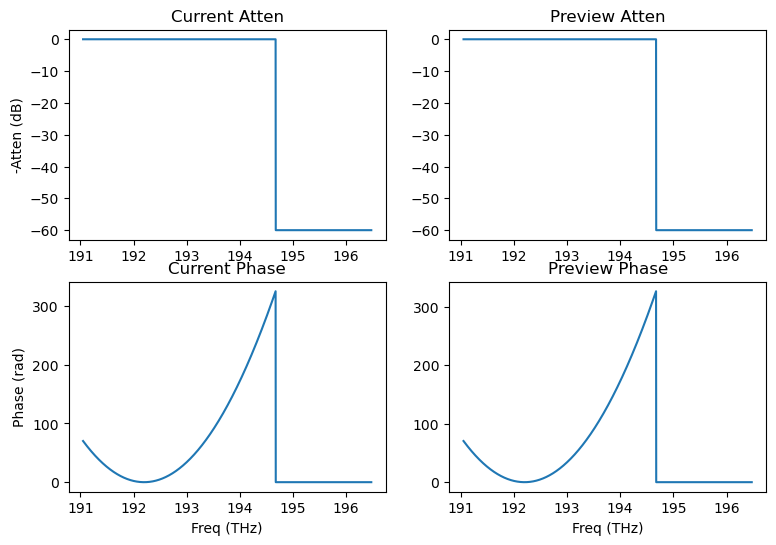

In [485]:

wsp.set3rdDisper(d2=2.09,d3=0.,center=1559.8)
wsp.setBandPass(span=5)
wsp.plotStatus()
wsp.writeProfile()

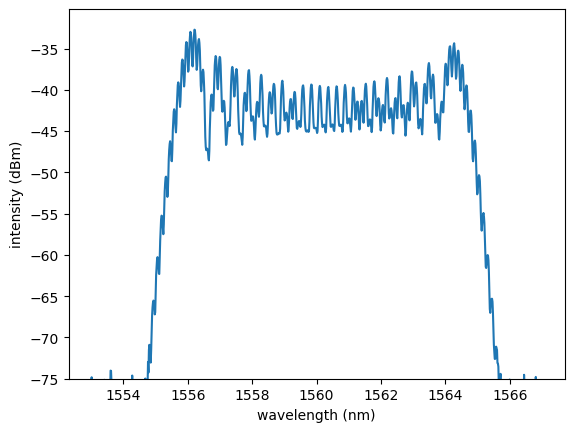

2024-12-06 07:10:33.264 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-75.77937 , -74.822075, -77.028275, ..., -77.09967 , -75.280235,
        -78.69521 ], dtype=float32))

In [40]:
osa.get_trace('a')

In [8]:
from KeckLFC.Hardware.SRS_SIM900 import SRS_SIM900, SRS_PIDcontrol_SIM960
srs = SRS_SIM900(addr='GPIB0::2::INSTR')
srs.connect()
servo_FC = SRS_PIDcontrol_SIM960(srs, 1, name='Filter Cavity PDH Lock Servo')
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')
servo_RB = SRS_PIDcontrol_SIM960(srs, 5, name='Rio Laser Fceo Rb spectroscopy Lock Servo')


2025-05-13 11:44:48.414 | INFO     | Stanford Research System SIM900 | Device.py:connect:78
Stanford Research System SIM900 connected


In [9]:
servo_IM.printStatus()

2025-05-13 11:44:57.498 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	PID,	Output limit: -3.000V TO 3.000V
|	Measured input:	 5.98771V
|	Amplified error:	 3.10548V
|	Instant Output voltage:	 3.107172V
|	Manual output set:	 0.12V
|	================ Set Point related================
|		Internal setpoint = 3.68 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input 3.677858V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = -2.0    , 	action = ON
|		 I = 0.1 1/s, 	action = ON
|		 D = 1e-05   s, 	action = OFF
|		Off = -1.0  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bPID\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 5.98771V\n|\tAmplified error:\t 3.10548V\n|\tInstant Output voltage:\t 3.107172V\n|\tManual output set:\t 0.12V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 3.68 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 3.677858V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = -2.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = -1.0  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [97]:
srs.disconnect()

2024-02-22 14:28:40.478 | INFO     | Stanford Research System SIM900 | Device.py:disconnect:90
Stanford Research System SIM900 disconnected


1

In [ ]:
from KeckLFC.Hardware.PritelAmp import PritelAmp

for i in range(3,23):
    try:
        ptamp = PritelAmp(addr=f"ASRL{i}::INSTR")
        ptamp.connect()
        ptamp.printStatus()

        print(f'com={i} success')
        
    except:
        # ptamp.disconnect()
        print(f'com={i} failed')

In [2]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [154]:
from KeckLFC.Hardware.PritelAmp import PritelAmp
ptamp = PritelAmp(addr=f'ASRL{7}::INSTR', name='Pritel Amp')
ptamp.connect()
ptamp.printStatus()


2025-05-15 14:10:51.682 | INFO     | Pritel Amp | PritelAmp.py:connect:60
Pritel Amp connected
2025-05-15 14:10:53.200 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: OFF
|	 InputPower = 0 mW, 	PreAmp = 0 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Enabled. PowerAmp pump current is disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bOFF\x1b\n|\t InputPower = 0 mW, \tPreAmp = 0 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Enabled. PowerAmp pump current is disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [213]:
ptamp.printStatus()

2025-05-16 09:28:45.273 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: ON
|	 InputPower = 140 mW, 	PreAmp = 604 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bON\x1b\n|\t InputPower = 140 mW, \tPreAmp = 604 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [161]:
ptamp.preAmp = 600

2025-05-15 14:12:45.909 | INFO     | Pritel Amp | PritelAmp.py:preAmp:115
Pritel Amp: Disable Ramping by self.ramp_pre_ma = 0, now 100 mA.
2025-05-15 14:12:46.605 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 600 mA, current Output 0.00 W.
2025-05-15 14:12:47.085 | INFO     | Pritel Amp | PritelAmp.py:preAmp:121
Pritel Amp: Setting PreAmp Current to 600 mA, current Output 0.00 W.


In [490]:
ptamp.activation=0

2025-05-28 11:17:31.961 | INFO     | Pritel Amp | PritelAmp.py:activation:206
Pritel Amp: setted Activation status as OFF, finished in 0.442 seconds


--- Logging error in Loguru Handler #2 ---
Record was: {'elapsed': datetime.timedelta(days=13, seconds=85730, microseconds=446696), 'exception': None, 'extra': {'devicename': 'Pritel Amp', 'function_module': 'PritelAmp.py', 'function_name': 'activation', 'function_line': 206}, 'file': (name='Device.py', path='c:\\Users\\KeckLFC\\KeckLFC-main\\KeckLFC\\Hardware\\Device.py'), 'function': 'info', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 111, 'message': 'Pritel Amp: setted Activation status as OFF, finished in 0.442 seconds', 'module': 'Device', 'name': 'KeckLFC.Hardware.Device', 'process': (id=2944, name='MainProcess'), 'thread': (id=17888, name='MainThread'), 'time': datetime(2025, 5, 28, 11, 17, 31, 961596, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=50400), 'Hawaiian Standard Time'))}
Traceback (most recent call last):
  File "c:\Users\KeckLFC\.conda\envs\lfc-env\Lib\site-packages\loguru\_handler.py", line 315, in _queued_writer
    self._sink.write(message)
 

In [ ]:
ptamp.easy_turnOn()# work now

In [488]:
ptamp.pwrAmp = '0A'

2025-05-17 14:12:30.882 | INFO     | Pritel Amp | PritelAmp.py:pwrAmp:151
Pritel Amp: Disable Ramping by self.ramp_pwr_ma = 0, now 50 mA.
--- Logging error in Loguru Handler #2 ---
Record was: {'elapsed': datetime.timedelta(days=3, seconds=9829, microseconds=367873), 'exception': None, 'extra': {'devicename': 'Pritel Amp', 'function_module': 'PritelAmp.py', 'function_name': 'pwrAmp', 'function_line': 151}, 'file': (name='Device.py', path='c:\\Users\\KeckLFC\\KeckLFC-main\\KeckLFC\\Hardware\\Device.py'), 'function': 'info', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 111, 'message': 'Pritel Amp: Disable Ramping by self.ramp_pwr_ma = 0, now 50 mA.', 'module': 'Device', 'name': 'KeckLFC.Hardware.Device', 'process': (id=2944, name='MainProcess'), 'thread': (id=17888, name='MainThread'), 'time': datetime(2025, 5, 17, 14, 12, 30, 882773, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=50400), 'Hawaiian Standard Time'))}
Traceback (most recent call last):
  File "c:\Users\K

In [ ]:
2025-05-17 12:15:31.822 | INFO     | Pritel Amp | PritelAmp.py:activation:206
Pritel Amp: setted Activation status as ON, finished in 0.449 seconds
--- Logging error in Loguru Handler #2 ---
Record was: {'elapsed': datetime.timedelta(days=3, seconds=2810, microseconds=307775), 'exception': None, 'extra': {'devicename': 'Pritel Amp', 'function_module': 'PritelAmp.py', 'function_name': 'activation', 'function_line': 206}, 'file': (name='Device.py', path='c:\\Users\\KeckLFC\\KeckLFC-main\\KeckLFC\\Hardware\\Device.py'), 'function': 'info', 'level': (name='INFO', no=20, icon='ℹ️'), 'line': 111, 'message': 'Pritel Amp: setted Activation status as ON, finished in 0.449 seconds', 'module': 'Device', 'name': 'KeckLFC.Hardware.Device', 'process': (id=2944, name='MainProcess'), 'thread': (id=17888, name='MainThread'), 'time': datetime(2025, 5, 17, 12, 15, 31, 822675, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=50400), 'Hawaiian Standard Time'))}
Traceback (most recent call last):
  File "c:\Users\KeckLFC\.conda\envs\lfc-env\Lib\site-packages\loguru\_handler.py", line 315, in _queued_writer
    self._sink.write(message)
  File "c:\Users\KeckLFC\.conda\envs\lfc-env\Lib\site-packages\loguru\_file_sink.py", line 204, in write
    self._terminate_file(is_rotating=True)
  File "c:\Users\KeckLFC\.conda\envs\lfc-env\Lib\site-packages\loguru\_file_sink.py", line 276, in _terminate_file
    os.rename(old_path, renamed_path)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\KeckLFC\\Desktop\\Keck\\Logs\\test.log' -> 'C:\\Users\\KeckLFC\\Desktop\\Keck\\Logs\\test.2025-05-15_14-00-08_093075.log'
--- End of logging error ---

In [9]:
ptamp.printStatus()

2024-10-01 18:11:54.805 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: ON
|	 InputPower = 138 mW, 	PreAmp = 603 mA
|	 OutputPower = 3.65 W, 	PwrAmp = 3.71 A
|	 AutoShutDown Disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bON\x1b\n|\t InputPower = 138 mW, \tPreAmp = 603 mA\n|\t OutputPower = 3.65 W, \tPwrAmp = 3.71 A\n|\t AutoShutDown Disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [36]:
ptamp.printStatus()

2024-07-20 10:34:23.606 | INFO     | Pritel Amp | PritelAmp.py:printStatus:38
------------------------------------Pritel Amp-----------------------------------
|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------
|	 Pump status: ON
|	 InputPower = 140 mW, 	PreAmp = 603 mA
|	 OutputPower = 0.00 W, 	PwrAmp = 0.00 A
|	 AutoShutDown Disabled.
----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------



'------------------------------------Pritel Amp-----------------------------------\n|-----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary------------------\n|\t Pump status: \x1bON\x1b\n|\t InputPower = 140 mW, \tPreAmp = 603 mA\n|\t OutputPower = 0.00 W, \tPwrAmp = 0.00 A\n|\t AutoShutDown Disabled.\n----------------Pritel OPTICAL FIBER AMPLIFIER Status Summary Ends---------------\n'

In [160]:
# ptamp.preAmp = '600mA'
# ptamp.pwrAmp = '0A'

ptamp.activation = 0

2024-04-17 14:19:44.189 | INFO     | Pritel Amp | PritelAmp.py:activation:203
Pritel Amp: ......waiting Activation status set to OFF, now ON
2024-04-17 14:19:44.861 | INFO     | Pritel Amp | PritelAmp.py:activation:206
Pritel Amp: setted Activation status as OFF, finished in 1.123 seconds


In [80]:
from KeckLFC.Hardware.AmonicsEDFA import AmonicsEDFA
amonic13 = AmonicsEDFA(addr=f'ASRL{9}::INSTR', name='Amonics EDFA 13 dBm')
amonic13.connect()
amonic13.printStatus()

2024-02-22 14:20:40.162 | INFO     | Amonics EDFA 13 dBm | Device.py:connect:78
Amonics EDFA 13 dBm connected
2024-02-22 14:20:46.424 | INFO     | Amonics EDFA 13 dBm | AmonicsEDFA.py:printStatus:49
-------------------------------Amonics EDFA 13 dBm-------------------------------
|--------------------------Amonics EDFA Status Summary---------------------------
|------------------Model: AEDFA-PM-13-R-FA, Serial No.22020701-------------------
|	InterLock Status: UNLOCKED
|	Case Temperature: 27.31°C
|	Master Activation: OFF
|	------------Channel Summary-------------
|	 CHANNEL1: 
|		 Mode: ACC
|		 Set Cur: 0.0 mA
|		 Status: OFF
|		 Input Power: 0.0 mW
|		 Output Power: 0.0 mW
|		 Internal PD Power: 0.0 mW
------------------------Amonics EDFA Status Summary Ends------------------------



'-------------------------------Amonics EDFA 13 dBm-------------------------------\n|--------------------------Amonics EDFA Status Summary---------------------------\n|------------------Model: AEDFA-PM-13-R-FA, Serial No.22020701-------------------\n|\tInterLock Status: \x1bUNLOCKED\x1b\n|\tCase Temperature: 27.31°C\n|\tMaster Activation: \x1bOFF\x1b\n|\t------------Channel Summary-------------\n|\t CHANNEL1: \n|\t\t Mode: ACC\n|\t\t Set Cur: 0.0 mA\n|\t\t Status: \x1bOFF\x1b\n|\t\t Input Power: 0.0 mW\n|\t\t Output Power: 0.0 mW\n|\t\t Internal PD Power: 0.0 mW\n------------------------Amonics EDFA Status Summary Ends------------------------\n'

In [3]:
cd ..

c:\Users\KeckLFC\KeckLFC-main


In [259]:
from KeckLFC.Hardware.Agiltron_2by2_switch import AgiltronSelfAlign22
sw2 = AgiltronSelfAlign22(addr=f'COM{20}')
sw2.connect()
sw2.check_status()

2025-05-16 11:51:17.056 | INFO     | Agiltron 2 by 2 switch | Device.py:connect:78
Agiltron 2 by 2 switch connected


1

In [261]:
sw2.set_status(2)

2025-05-16 11:51:24.079 | INFO     | Agiltron 2 by 2 switch | Agiltron_2by2_switch.py:set_status:113
status set to 2


In [262]:
sw2.check_status()

2

In [263]:
sw2.disconnect()

2025-05-16 11:51:28.353 | INFO     | Agiltron 2 by 2 switch | Device.py:disconnect:90
Agiltron 2 by 2 switch disconnected


1

In [ ]:
################ locking all 2024-04-08

In [16]:
from KeckLFC.Hardware.SRS_SIM900 import SRS_SIM900, SRS_PIDcontrol_SIM960
srs = SRS_SIM900(addr='GPIB0::2::INSTR')
srs.connect()
servo_FC = SRS_PIDcontrol_SIM960(srs, 1, name='Filter Cavity PDH Lock Servo')
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')
servo_RB = SRS_PIDcontrol_SIM960(srs, 5, name='Rio Laser Fceo Rb spectroscopy Lock Servo')

from KeckLFC.Hardware.TDS2024C import TDS2024C
osc = TDS2024C()
osc.connect()

from KeckLFC.Hardware.KeysightFG_33500 import KeysightFG_33500
fg = KeysightFG_33500(addr='USB0::0x0957::0x2807::MY59003824::INSTR', name='Keysight FG 33500')
fg.connect()

2024-11-14 12:29:58.389 | INFO     | Stanford Research System SIM900 | Device.py:connect:78
Stanford Research System SIM900 connected
2024-11-14 12:29:58.422 | INFO     | TDS2024C OSC | Device.py:connect:78
TDS2024C OSC connected
2024-11-14 12:29:58.427 | INFO     | Keysight FG 33500 | Device.py:connect:78
Keysight FG 33500 connected


1

In [12]:
from KeckLFC.Hardware.KeysightFG_33500 import KeysightFG_33500
fg = KeysightFG_33500(addr='USB0::0x0957::0x2807::MY59003824::INSTR', name='Keysight FG 33500')
fg.connect()

fg_pdh = KeysightFG_33500(addr='USB0::0x0957::0x2807::MY62003852::INSTR', name='Keysight FG 33500 for pdh')
fg_pdh.connect()

2025-05-13 12:27:01.005 | INFO     | Keysight FG 33500 | Device.py:connect:78
Keysight FG 33500 connected
2025-05-13 12:27:01.021 | INFO     | Keysight FG 33500 for pdh | Device.py:connect:78
Keysight FG 33500 for pdh connected


1

In [15]:
fg_pdh.get_channel_parameters(1)

{'channel': '1',
 'frequency': '10000000.0',
 'Amplitude': '0.1',
 'offset': '0.0',
 'phase': '0.0',
 'state': '0\n',
 'function': 'SIN\n'}

In [68]:
servo_IM.output_upperlim = 3
servo_IM.output_lowerlim = -3
servo_IM.printStatus()


2025-04-07 12:26:49.177 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output Upper limit in Volt to 3.0.
2025-04-07 12:26:49.381 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output Lower limit in Volt to -3.0.
2025-04-07 12:26:54.454 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	MAN,	Output limit: -3.000V TO 3.000V
|	Measured input:	 3.688505V
|	Amplified error:	 -0.836225V
|	Instant Output voltage:	 0.116909V
|	Manual output set:	 0.12V
|	================ Set Point related================
|		Internal setpoint = 3.48 V, Ramping OFF
|		Setpoint input mode 

'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bMAN\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 3.688505V\n|\tAmplified error:\t -0.836225V\n|\tInstant Output voltage:\t 0.116909V\n|\tManual output set:\t 0.12V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 3.48 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 3.478039V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 4.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = -1.0  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

2025-05-13 12:46:01.420 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:666
Minicomb Intensity Lock Servo: ....Manual output voltage Ramping.... Disable ranp by set self.manual_output_ramp=0. 
2025-05-13 12:46:01.630 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.500.
2025-05-13 12:46:01.833 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.607.
2025-05-13 12:46:02.046 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.714.
2025-05-13 12:46:02.256 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to -0.821.
2025-05-13 12:46:02.464 | INFO     | Minicomb Intensit

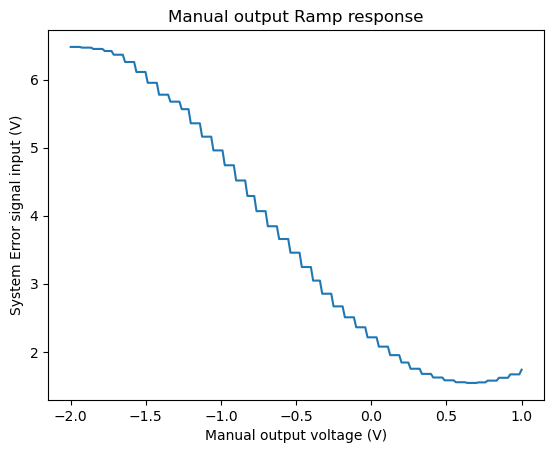

2025-05-13 12:46:31.807 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:666
Minicomb Intensity Lock Servo: ....Manual output voltage Ramping.... Disable ranp by set self.manual_output_ramp=0. 
2025-05-13 12:46:32.014 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 1.000.
2025-05-13 12:46:32.229 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.893.
2025-05-13 12:46:32.440 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.786.
2025-05-13 12:46:32.647 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_manual_output:671
Minicomb Intensity Lock Servo: Output in Manual Mode in Volt set to 0.679.
2025-05-13 12:46:32.854 | INFO     | Minicomb Intensity Lo

In [28]:
import numpy as np
scan_start = -2
scan_stop =1
num_steps= 200

servo_IM.manual_output_ramp=0.1
servo_IM.manual_output = scan_start

r = servo_IM.manual_sweep(np.linspace(scan_start,scan_stop,num_steps))

servo_IM.manual_output=-0.5

In [534]:
servo_IM = SRS_PIDcontrol_SIM960(srs, 3, name='Minicomb Intensity Lock Servo')

2025-04-07 11:42:52.235 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output in Manual Mode in Volt to 0.12.
2025-04-07 11:42:52.750 | INFO     | RF oscilator PS, CH2 15V, CH3 1V | InstekGPD_4303S.py:_setVSET:320
Instek GPD-4303S DCSupply: VSET channel 3 set to 0.750V
2025-04-07 11:42:54.758 | INFO     | Agilent 86142B | Agilent_86142B.py:Run:164
Agilent 86142B: Spectrum collection RUN (repeat) start.


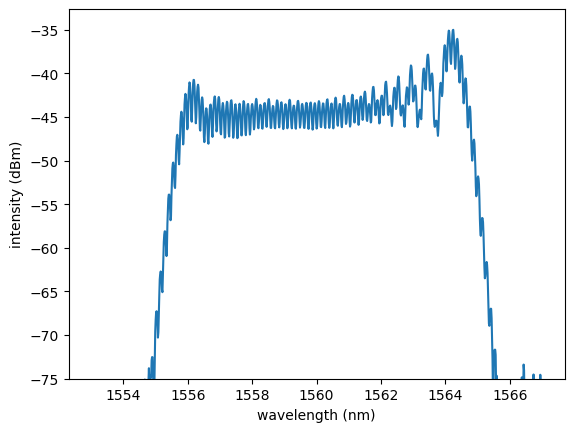

2025-04-07 11:42:55.656 | INFO     | Agilent 86142B | Agilent_86142B.py:get_trace:327
Agilent 86142B: Trace A data is collected and is shown in the plot.


(array([1553.   , 1553.014, 1553.028, ..., 1566.972, 1566.986, 1567.   ],
       dtype=float32),
 array([-82.494156, -82.494156, -82.494156, ..., -79.46384 , -79.01822 ,
        -76.42854 ], dtype=float32))

In [66]:
import time
servo_IM.manual_output = 0.12
rfoscPS.Vset3=0.75
time.sleep(2)
osa.Run()
osa.get_trace('a')

In [44]:
servo_IM.prop_gain=-2  #-2 or 4
servo_IM.intg_gain=0.1   #1
servo_IM.outoffset=-0.6
servo_IM.set_setpoint(3.51)

2025-05-13 12:50:08.124 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Proportional Gain in V/V to -2.0.
2025-05-13 12:50:08.332 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Integral Gain in 1/seconds to 0.1.
2025-05-13 12:50:08.539 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Output offset in Volts to -0.6.
2025-05-13 12:50:08.749 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:__set_num_withcmd:812
Minicomb Intensity Lock Servo: Setting Locking set point in Volt to 3.51.


In [45]:
servo_IM.output_mode = 'pid'  #'man'  or 'pid'

2025-05-13 12:50:12.149 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:set_output_mode:534
Minicomb Intensity Lock Servo: PID output is turned ON.


In [43]:
servo_IM.printStatus()

2025-05-13 12:49:15.465 | INFO     | Minicomb Intensity Lock Servo | SRS_SIM900.py:printStatus:201
--------------------------Minicomb Intensity Lock Servo--------------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033669,ver2.17----------------------------
|	Output mode:	MAN,	Output limit: -3.000V TO 3.000V
|	Measured input:	 3.512289V
|	Amplified error:	 -0.338251V
|	Instant Output voltage:	 -0.603465V
|	Manual output set:	 -0.6V
|	================ Set Point related================
|		Internal setpoint = 3.68 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input 3.677866V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = -2.0    , 	action = ON
|		 I = 0.1 1/s, 	action = ON
|		 D = 1e-05   s, 	action = OFF
|		Off = -1.0  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------------Minicomb Intensity Lock Servo--------------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033669,ver2.17----------------------------\n|\tOutput mode:\t\x1bMAN\x1b,\tOutput limit: -3.000V TO 3.000V\n|\tMeasured input:\t 3.512289V\n|\tAmplified error:\t -0.338251V\n|\tInstant Output voltage:\t -0.603465V\n|\tManual output set:\t -0.6V\n|\t================ Set Point related================\n|\t\tInternal setpoint = 3.68 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input 3.677866V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = -2.0    , \taction = \x1bON\x1b\n|\t\t I = 0.1 1/s, \taction = \x1bON\x1b\n|\t\t D = 1e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = -1.0  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [46]:
# servo_IM.output_mode = 'man'  #'man'  or 'pid'
# servo_IM.output_mode = 'pid'  #'man'  or 'pid'
import time
for i in range(20):

    print(servo_IM.get_output_voltage() ) 
    time.sleep(0.5)

-0.603028
-0.603281
-0.603362
-0.603564
-0.603441
-0.603513
-0.603722
-0.603601
-0.603744
-0.603534
-0.603443
-0.603313
-0.603155
-0.603159
-0.602653
-0.601908
-0.601813
-0.601532
-0.601161
-0.600951


In [240]:
from KeckLFC.Hardware.hk_shutter import hk_shutter
hks = hk_shutter(addr='COM17')   #5,8,11,14,17
hks.connect()

2025-05-16 11:18:12.395 | INFO     | hk_shutter | hk_shutter.py:connect:31
hk_shutter connected


1

In [244]:
hks.get_status()

2025-05-16 11:18:42.213 | INFO     | hk_shutter | hk_shutter.py:get_status:93
Shutter is 1


1

In [83]:
hks.get_mode()

Shutter is in Manual mode


1

In [243]:
hks.set_status(1)

2025-05-16 11:18:23.744 | INFO     | hk_shutter | hk_shutter.py:get_status:90
Shutter is 0
2025-05-16 11:18:25.767 | INFO     | hk_shutter | hk_shutter.py:get_status:93
Shutter is 1


Shutter is set to 1


1

In [18]:
hks.disconnect()

2025-05-15 10:48:58.263 | INFO     | hk_shutter | hk_shutter.py:disconnect:44
hk_shutter disconnected


1

In [278]:
arduino.shut_YJ()

'YJShut\r\r\nYJ shutter is UP, YJ is shutted.'

In [9]:
from KeckLFC.Hardware.TDS2024C import TDS2024C
osc = TDS2024C()
osc.connect()

2024-11-14 12:25:50.352 | INFO     | TDS2024C OSC | Device.py:connect:78
TDS2024C OSC connected


1

In [ ]:
osc.get_trace(trace=4)

In [ ]:
osc.query('CH1:VOL 2')

In [22]:
osc.write("ACQuire:STATE RUN")

In [25]:
osc.query('CH1:SCA?')

'2.0E0'

In [277]:
a=1
osc.write(f'CH{a}:SCA 3')

In [331]:
osc.query('HOR:SCA?')

'1.0E-1'

In [281]:
osc.write('HOR:POS 1')

In [308]:
osc.write('TRIG:MAI:EDGE:SOU EXT')

In [26]:
osc.query('TRIG:MAI:EDGE:SOU?')

'EXT'

In [307]:
osc.query('TRIG:MAI:LEV?')

'2.0E-1'

In [328]:
osc.query('CH1:POS?')

'3.0E0'

In [327]:
osc.write('CH1:POS 3')

In [27]:
osc.query('SEL?')

'1;1;0;0;0;0;0;0;0'

In [347]:
osc.write('SEL:CH4 ON')

In [364]:

def set_vol_pos(self,channle,pos):

    self.write(f'CH{channle}:POS {pos}')
    print(f'CH{channle} set to '+ self.query(f'CH{channle}:POS?'))
    #return self.query(f'CH{channle}:POS?')

def set_vol_scale(self,channle,sca):

    self.write(f'CH{channle}:SCA {sca}')
    print(f'CH{channle} set to '+self.query(f'CH{channle}:SCA?'))
    #return self.query(f'CH{channle}:SCA?')

def set_time_pos(self,pos):
    self.write(f'HOR:POS {pos}')
    print(f'time pos set to '+self.query(f'HOR:POS?'))

def set_time_scale(self,sca):

    self.write(f'HOR:SCA {sca}')
    print(f'time scale set to '+self.query(f'HOR:SCA?'))

def trace_disp(self,chan,state):

    if (state == 1) or( state=='ON'):
        self.write(f'SEL:CH{chan} ON')
    if (state == 0) or(state== 'OFF'):
        self.write(f'SEL:CH{chan} OFF')
    print(f'display set to '+self.query('SEL?'))

def set_trigger_source(self,chan):

    self.write(f'TRIG:MAI:EDGE:SOU {chan}')
    print(f'trigger souce set to '+self.query(f'TRIG:MAI:EDGE:SOU?'))

def set_trigger_lev(self,lvl):
    self.write(f'TRIG:MAI:LEV {lvl}')
    print(f'trigger level set to '+self.query('TRIG:MAI:LEV?'))

In [395]:
set_time_pos(osc,0)

time pos set to 0.0E0


In [402]:
set_trigger_lev(osc, 2)

trigger level set to 2.0E0


In [394]:
set_trigger_source(osc,'CH4')

trigger souce set to CH4


In [440]:
set_vol_pos(osc, 1, -1.5)


CH1 set to -1.48E0


'-1.48E0'

In [443]:
set_vol_scale(osc,2,0.01)

CH2 set to 1.0E-2


'1.0E-2'

In [431]:
set_vol_scale(osc,1,0.03)

set_vol_scale(osc,2,0.03)

set_vol_scale(osc,3,0.03)


CH1 set to 3.0E-2
CH2 set to 3.0E-2
CH3 set to 3.0E-2


'3.0E-2'

In [375]:
set_trigger_lev(osc,0.2)

trigger level set to 2.0E-1


In [424]:
set_time_scale(osc,0.05)

time scale set to 5.0E-2


In [433]:
trace_disp(self=osc,chan=3,state=1)
# chan=1
# osc.write(f'SEL:CH{chan} ON')

display set to 1;1;1;1;0;0;0;0;0


2024-11-14 12:33:38.712 | INFO     | TDS2024C OSC | TDS2024C.py:get_trace:134
TDS2024C OSC: Trace 2 data read finished.


{'BYT_Nr': 2,
 'BIT_Nr': 16,
 'ENCd': 'ASC',
 'BN_Fmt': 'RP',
 'BYT_Or': 'MSB',
 'NR_Pt': 2500,
 'WFID': '"Ch2, DC coupling, 1.0E0 V/div, 1.0E-2 s/div, 2500 points, Sample mode"',
 'PT_FMT': 'Y',
 'XINcr': 4e-05,
 'PT_Off': 0.0,
 'XZEro': -0.05,
 'XUNit': '"s"',
 'YMUlt': 0.00015625,
 'YZEro': 0.0,
 'YOFF': -11776.0,
 'YUNit': '"Volts"',
 'Y': array([2.52, 2.52, 2.52, ..., 2.52, 2.52, 2.56]),
 'X': array([-0.05   , -0.04996, -0.04992, ...,  0.04988,  0.04992,  0.04996])}

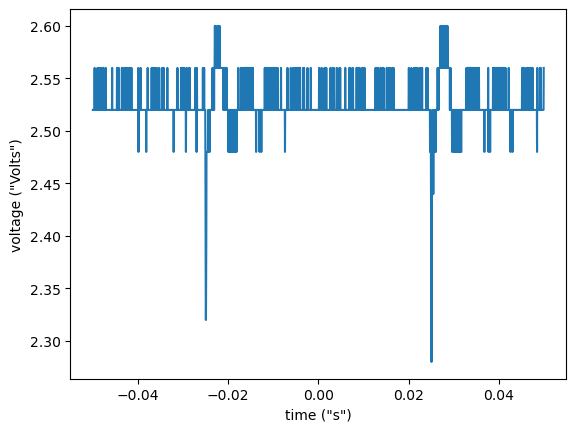

In [21]:
osc.get_trace(2)

In [6]:
from KeckLFC.Hardware import autolock
import time
import matplotlib.pyplot as plt
autolock = autolock.AutoRbLock(osc, fg, servo_RB)

In [303]:
fg.set_trigger_source(1)

trig source=CH1



In [334]:
servo_RB.output_voltage

0.01515

In [412]:
fg.set_trigger_type(1, 'IMM')

In [413]:
fg.query("TRIG1:SOUR?")

'IMM\n'

In [16]:

fg.get_channel_parameters(1)

{'channel': '1',
 'frequency': '10.0',
 'Amplitude': '8.0',
 'offset': '0.0',
 'phase': '0.0',
 'state': '0\n',
 'function': 'RAMP\n'}

In [422]:
servo_RB.printStatus()

2024-04-12 13:45:21.732 | INFO     | Rio Laser Fceo Rb spectroscopy Lock Servo | SRS_SIM900.py:printStatus:201
--------------------Rio Laser Fceo Rb spectroscopy Lock Servo--------------------
|--------------------SRS PID controller SIM960 Status Summary--------------------
|----------------------------SIM960,s/n033683,ver2.17----------------------------
|	Output mode:	MAN,	Output limit: -4.000V TO 4.000V
|	Measured input:	 0.002018V
|	Amplified error:	 -0.007743V
|	Instant Output voltage:	 -0.005581V
|	Manual output set:	 0.0V
|	================ Set Point related================
|		Internal setpoint = -0.01 V, Ramping OFF
|		Setpoint input mode INT, Ext setpoint input -0.009426V
|		Setpoint RAMP speed = 0.01 V/s, action OFF
|	============= P,I,D and Offset Status=============
|		 P = 0.7    , 	action = ON
|		 I = 1500.0 1/s, 	action = ON
|		 D = 6e-05   s, 	action = OFF
|		Off = 0.0  V, 	action = ON
-----------------SRS PID controller SIM960 Status Summary Ends------------------



'--------------------Rio Laser Fceo Rb spectroscopy Lock Servo--------------------\n|--------------------SRS PID controller SIM960 Status Summary--------------------\n|----------------------------SIM960,s/n033683,ver2.17----------------------------\n|\tOutput mode:\t\x1bMAN\x1b,\tOutput limit: -4.000V TO 4.000V\n|\tMeasured input:\t 0.002018V\n|\tAmplified error:\t -0.007743V\n|\tInstant Output voltage:\t -0.005581V\n|\tManual output set:\t 0.0V\n|\t================ Set Point related================\n|\t\tInternal setpoint = -0.01 V, Ramping \x1bOFF\x1b\n|\t\tSetpoint input mode INT, Ext setpoint input -0.009426V\n|\t\tSetpoint RAMP speed = 0.01 V/s, action \x1bOFF\x1b\n|\t============= P,I,D and Offset Status=============\n|\t\t P = 0.7    , \taction = \x1bON\x1b\n|\t\t I = 1500.0 1/s, \taction = \x1bON\x1b\n|\t\t D = 6e-05   s, \taction = \x1bOFF\x1b\n|\t\tOff = 0.0  V, \taction = \x1bON\x1b\n-----------------SRS PID controller SIM960 Status Summary Ends------------------\n'

In [15]:
#servo_RB.output_mode='man'
fg.set_channel_parameters(channel=1, freq=10, amp=8, offset=0, phase=0)
fg.set_channel_func(1, 'ramp')
fg.set_channel_state(1, 0)
# time.sleep(10)
# trace_x,trace_y=autolock.get_trace(trace = 1)
# plt.plot(trace_x,trace_y)

RAMP



2024-11-18 10:28:44.669 | INFO     | TDS2024C OSC | TDS2024C.py:get_trace:134
TDS2024C OSC: Trace 2 data read finished.


{'BYT_Nr': 2,
 'BIT_Nr': 16,
 'ENCd': 'ASC',
 'BN_Fmt': 'RP',
 'BYT_Or': 'MSB',
 'NR_Pt': 2500,
 'WFID': '"Ch2, DC coupling, 1.0E0 V/div, 1.0E-2 s/div, 2500 points, Sample mode"',
 'PT_FMT': 'Y',
 'XINcr': 4e-05,
 'PT_Off': 0.0,
 'XZEro': -0.05,
 'XUNit': '"s"',
 'YMUlt': 0.00015625,
 'YZEro': 0.0,
 'YOFF': -11776.0,
 'YUNit': '"Volts"',
 'Y': array([2.08, 2.44, 1.96, ..., 2.32, 2.28, 2.2 ]),
 'X': array([-0.05   , -0.04996, -0.04992, ...,  0.04988,  0.04992,  0.04996])}

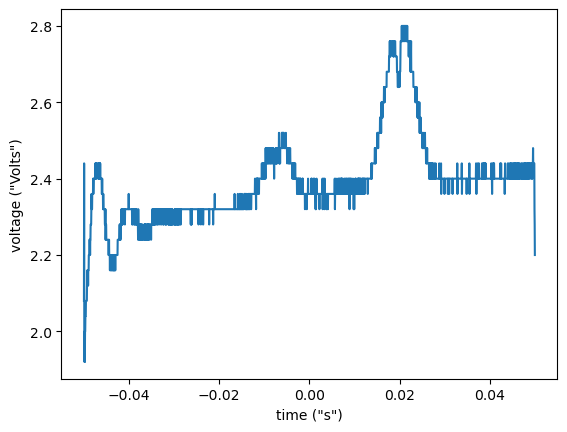

In [57]:
osc.get_trace(trace=2)

In [8]:
from KeckLFC.Hardware.ORIONLaser import ORIONLaser
rio = ORIONLaser(addr=f'ASRL{14}::INSTR')
rio.connect()
rio.printStatus()

2024-11-14 12:20:31.936 | INFO     | ORION Laser Module | Device.py:connect:78
ORION Laser Module connected


0
1
0


2024-11-14 12:20:33.287 | INFO     | ORION Laser Module | ORIONLaser.py:printStatus:60
-----------------------ORION Laser Module Status Summary------------------------
-------------Product ID: RIO0175-5-01-4-AW2, Ver 0.11.7, SN: 806734-------------
|	 Status Code: bytearray(b'\x00\x01\x00\x01\x00\x01')
|	 Photo monitor voltage: 1.320 Volt (also mA, r=1kOhm)
|	 Board Temp:   22.0856 °C
|	 Thermis Temp: 25.6517 °C
|	 Volatile Settings (reset to non-volatile after re-plug): 
|		 Diode Cur = 145.0000 mA, TEC Set = 25.902°C
|	 Non Volatile Settings (Doesn't reset after re-plug): 
|		 Diode Cur = 145.0000 mA, TEC Set = 25.902°C
---------------------ORION Laser Module Status Summary Ends---------------------


"-----------------------ORION Laser Module Status Summary------------------------\n-------------Product ID: RIO0175-5-01-4-AW2, Ver 0.11.7, SN: 806734-------------\n|\t Status Code: bytearray(b'\\x00\\x01\\x00\\x01\\x00\\x01')\n|\t Photo monitor voltage: 1.320 Volt (also mA, r=1kOhm)\n|\t Board Temp:   22.0856 °C\n|\t Thermis Temp: 25.6517 °C\n|\t Volatile Settings (reset to non-volatile after re-plug): \n|\t\t Diode Cur = 145.0000 mA, TEC Set = 25.902°C\n|\t Non Volatile Settings (Doesn't reset after re-plug): \n|\t\t Diode Cur = 145.0000 mA, TEC Set = 25.902°C\n---------------------ORION Laser Module Status Summary Ends---------------------"

In [ ]:
rio.writeLaserdiodeCur_mA(150)
rio.writeTECsetpoint(19.181+4.1)
rio.printStatus()
osc.get_trace(trace=2)


2024-11-14 13:31:03.822 | INFO     | TDS2024C OSC | TDS2024C.py:get_trace:134
TDS2024C OSC: Trace 2 data read finished.


{'BYT_Nr': 2,
 'BIT_Nr': 16,
 'ENCd': 'ASC',
 'BN_Fmt': 'RP',
 'BYT_Or': 'MSB',
 'NR_Pt': 2500,
 'WFID': '"Ch2, DC coupling, 1.0E0 V/div, 1.0E-2 s/div, 2500 points, Sample mode"',
 'PT_FMT': 'Y',
 'XINcr': 4e-05,
 'PT_Off': 0.0,
 'XZEro': -0.05,
 'XUNit': '"s"',
 'YMUlt': 0.00015625,
 'YZEro': 0.0,
 'YOFF': -11776.0,
 'YUNit': '"Volts"',
 'Y': array([2.08, 2.32, 1.88, ..., 2.32, 2.24, 2.12]),
 'X': array([-0.05   , -0.04996, -0.04992, ...,  0.04988,  0.04992,  0.04996])}

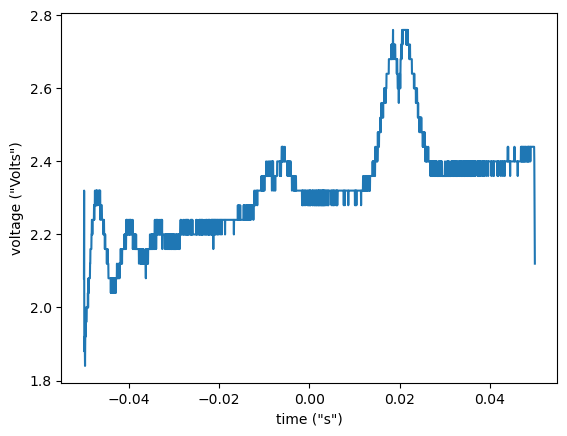

In [54]:
osc.get_trace(trace=2)

In [23]:
rio.writeLaserdiodeCur_mA(150, volatile=False)
#rio.writeTECsetpoint(19.181, volatile=False)
rio.printStatus()


0
1
0


2024-11-14 12:39:33.984 | INFO     | ORION Laser Module | ORIONLaser.py:printStatus:60
-----------------------ORION Laser Module Status Summary------------------------
-------------Product ID: RIO0175-5-01-4-AW2, Ver 0.11.7, SN: 806734-------------
|	 Status Code: bytearray(b'\x00\x01\x00\x01\x00\x01')
|	 Photo monitor voltage: 1.315 Volt (also mA, r=1kOhm)
|	 Board Temp:   22.1827 °C
|	 Thermis Temp: 25.7037 °C
|	 Volatile Settings (reset to non-volatile after re-plug): 
|		 Diode Cur = 150.0000 mA, TEC Set = 25.902°C
|	 Non Volatile Settings (Doesn't reset after re-plug): 
|		 Diode Cur = 150.0000 mA, TEC Set = 25.902°C
---------------------ORION Laser Module Status Summary Ends---------------------


"-----------------------ORION Laser Module Status Summary------------------------\n-------------Product ID: RIO0175-5-01-4-AW2, Ver 0.11.7, SN: 806734-------------\n|\t Status Code: bytearray(b'\\x00\\x01\\x00\\x01\\x00\\x01')\n|\t Photo monitor voltage: 1.315 Volt (also mA, r=1kOhm)\n|\t Board Temp:   22.1827 °C\n|\t Thermis Temp: 25.7037 °C\n|\t Volatile Settings (reset to non-volatile after re-plug): \n|\t\t Diode Cur = 150.0000 mA, TEC Set = 25.902°C\n|\t Non Volatile Settings (Doesn't reset after re-plug): \n|\t\t Diode Cur = 150.0000 mA, TEC Set = 25.902°C\n---------------------ORION Laser Module Status Summary Ends---------------------"

In [4]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa1550 = OZopticsVOA(addr=f'ASRL{15}::INSTR', name='1.55um VOA')
voa1550.connect()
voa1550.printStatus()

2025-05-28 14:53:51.447 | INFO     | 1.55um VOA | Device.py:connect:88
1.55um VOA connected
2025-05-28 14:53:52.122 | INFO     | 1.55um VOA | OZopticsVOA.py:printStatus:44
-----------------------------------1.55um VOA-----------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 40.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V6.4
|		NO:303700-01
|		MAX ATTEN:61.00
|		OVERSHOOT:-30
|		CALIB:FEB-22-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1550
|		I2C ADDRESS:64
|		W0 1550
-----------------------OZ optics VOA Status Summary Ends------------------------



'-----------------------------------1.55um VOA-----------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 40.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV6.4\n|\t\tNO:303700-01\n|\t\tMAX ATTEN:61.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:FEB-22-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1550\n|\t\tI2C ADDRESS:64\n|\t\tW0 1550\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [33]:
voa1550.printStatus()

2024-07-25 13:08:36.169 | INFO     | 1.55um VOA | OZopticsVOA.py:printStatus:44
-----------------------------------1.55um VOA-----------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 10.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V6.4
|		NO:303700-01
|		MAX ATTEN:61.00
|		OVERSHOOT:-30
|		CALIB:FEB-22-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1550
|		I2C ADDRESS:64
|		W0 1550
-----------------------OZ optics VOA Status Summary Ends------------------------



'-----------------------------------1.55um VOA-----------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 10.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV6.4\n|\t\tNO:303700-01\n|\t\tMAX ATTEN:61.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:FEB-22-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1550\n|\t\tI2C ADDRESS:64\n|\t\tW0 1550\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [281]:
voa1550.atten_db=0 #34

2025-05-16 13:48:34.207 | INFO     | 1.55um VOA | OZopticsVOA.py:_setAttenStr:61
1.55um VOA: VOA attenuation setted to 0.00 dB.


In [282]:
voa2000.atten_db=0

2025-05-16 13:48:36.457 | INFO     | 2um VOA | OZopticsVOA.py:_setAttenStr:61
2um VOA: VOA attenuation setted to 0.00 dB.


In [100]:
voa1550.disconnect()
voa1310.disconnect()
voa2000.disconnect()

2024-07-26 10:44:19.425 | INFO     | 1.55um VOA | Device.py:disconnect:90
1.55um VOA disconnected
2024-07-26 10:44:19.427 | INFO     | 1um VOA | Device.py:disconnect:90
1um VOA disconnected
2024-07-26 10:44:19.430 | INFO     | 2um VOA | Device.py:disconnect:90
2um VOA disconnected


1

2024-04-17 13:42:54.402 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:90
Waveshaper Set 3rd disper with d2=-2.71 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-04-17 13:42:54.408 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:127
Waveshaper Set atten to BandPass [189.675~194.675] THz ([1580.559~1539.964] nm).
2024-04-17 13:42:55.826 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:226
Waveshaper profile write successful.


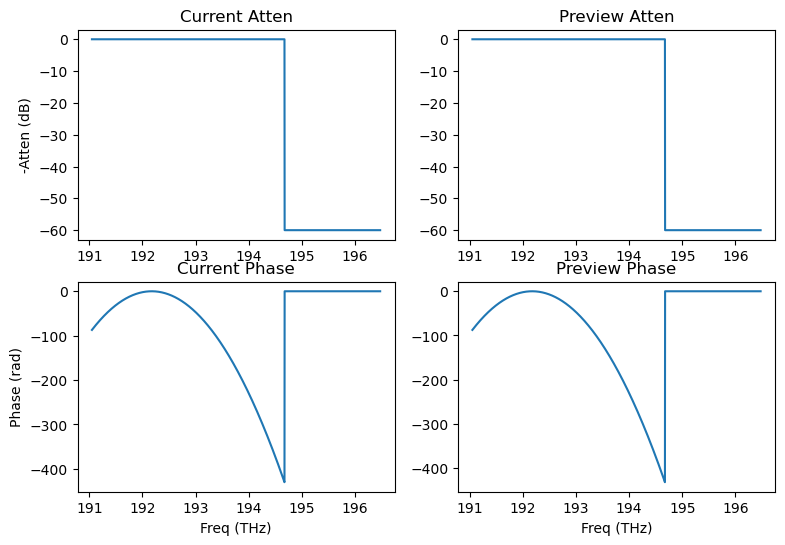

In [152]:
wsp.set3rdDisper(d2=-2.71,d3=0.)
wsp.setBandPass(span=5)
wsp.plotStatus()
wsp.writeProfile()

In [187]:
voa2000.printStatus()

2024-04-10 14:27:38.528 | INFO     | 2um VOA | OZopticsVOA.py:printStatus:44
------------------------------------2um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 10.00 (dB)
|	 Device Configure String:
|		DD100MC
|		V6.2a
|		NO:303699-01
|		MAX ATTEN:55.00
|		OVERSHOOT:-30
|		CALIB:MAR-02-2022
|		GEAR RATIO:485:1
|		MINTERVAL(MS):0.90
|		MOTOR VOLT:5
|		IL:0.00
|		WAVELENGTH:2000
|		I2C ADDRESS:64
|		W0 2000
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------2um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 10.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC\n|\t\tV6.2a\n|\t\tNO:303699-01\n|\t\tMAX ATTEN:55.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:MAR-02-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMINTERVAL(MS):0.90\n|\t\tMOTOR VOLT:5\n|\t\tIL:0.00\n|\t\tWAVELENGTH:2000\n|\t\tI2C ADDRESS:64\n|\t\tW0 2000\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [20]:
voa1550.atten_db

60.0

In [19]:
voa2000.atten_db

55.0

In [ ]:
voa1310

In [258]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa2000 = OZopticsVOA(addr=f'ASRL{18}::INSTR', name='2um VOA')
voa2000.connect()
voa2000.printStatus()

2025-05-16 11:50:49.163 | INFO     | 2um VOA | Device.py:connect:78
2um VOA connected
2025-05-16 11:50:49.764 | INFO     | 2um VOA | OZopticsVOA.py:printStatus:44
------------------------------------2um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 20.00 (dB)
|	 Device Configure String:
|		DD100MC
|		V6.2a
|		NO:303699-01
|		MAX ATTEN:55.00
|		OVERSHOOT:-30
|		CALIB:MAR-02-2022
|		GEAR RATIO:485:1
|		MINTERVAL(MS):0.90
|		MOTOR VOLT:5
|		IL:0.00
|		WAVELENGTH:2000
|		I2C ADDRESS:64
|		W0 2000
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------2um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 20.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC\n|\t\tV6.2a\n|\t\tNO:303699-01\n|\t\tMAX ATTEN:55.00\n|\t\tOVERSHOOT:-30\n|\t\tCALIB:MAR-02-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMINTERVAL(MS):0.90\n|\t\tMOTOR VOLT:5\n|\t\tIL:0.00\n|\t\tWAVELENGTH:2000\n|\t\tI2C ADDRESS:64\n|\t\tW0 2000\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [11]:
voa2000.atten_db=55

2024-08-22 07:25:54.545 | INFO     | 2um VOA | OZopticsVOA.py:_setAttenStr:61
2um VOA: VOA attenuation setted to 55.00 dB.


In [83]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
voa1310 = OZopticsVOA(addr=f'ASRL{19}::INSTR', name='1um VOA')
voa1310.connect()
voa1310.printStatus()

2025-04-15 07:44:08.197 | INFO     | 1um VOA | Device.py:connect:78
1um VOA connected
2025-04-15 07:44:08.828 | INFO     | 1um VOA | OZopticsVOA.py:printStatus:44
------------------------------------1um VOA-------------------------------------
--------------------------OZ optics VOA Status Summary--------------------------
|	 Attenuation: 55.00 (dB)
|	 Device Configure String:
|		DD100MC 
|		V1.1
|		NO:311029-01
|		MAX ATTEN:60.00
|		OVERSHOOT:0
|		CALIB:NOV-18-2022
|		GEAR RATIO:485:1
|		MOTOR VOLT:5V
|		MINTERVAL(MS):0.90
|		IL:0.00
|		WAVELENGTH:1310
|		I2C ADDRESS:64
|		W0 0980
|		W1 1310
-----------------------OZ optics VOA Status Summary Ends------------------------



'------------------------------------1um VOA-------------------------------------\n--------------------------OZ optics VOA Status Summary--------------------------\n|\t Attenuation: 55.00 (dB)\n|\t Device Configure String:\n|\t\tDD100MC \n|\t\tV1.1\n|\t\tNO:311029-01\n|\t\tMAX ATTEN:60.00\n|\t\tOVERSHOOT:0\n|\t\tCALIB:NOV-18-2022\n|\t\tGEAR RATIO:485:1\n|\t\tMOTOR VOLT:5V\n|\t\tMINTERVAL(MS):0.90\n|\t\tIL:0.00\n|\t\tWAVELENGTH:1310\n|\t\tI2C ADDRESS:64\n|\t\tW0 0980\n|\t\tW1 1310\n-----------------------OZ optics VOA Status Summary Ends------------------------\n'

In [84]:
voa1310.atten_db

55.0

In [88]:
voa1310.connect()
voa1310.inst.clear()

2025-04-15 08:04:17.510 | INFO     | 1um VOA | Device.py:connect:78
1um VOA connected


In [ ]:
from KeckLFC.Hardware.OZopticsVOA import OZopticsVOA
import time
voa1310 = OZopticsVOA(addr=f'ASRL{19}::INSTR', name='1um VOA')

for i in range(3000):
    try:
        voa1310.connect()
        print(f"Iteration {i}: Attenuation = {voa1310.atten_db} dB")
        voa1310.disconnect()
    except Exception as e:
        print(f"Iteration {i}: Error occurred - {e}")

        
    time.sleep(1800)

In [10]:
from KeckLFC.Hardware.TEC_TC720 import TEC_TC720
# tec_PPLN = TEC_TC720(addr='ASRL46::INSTR')
tec_wg = TEC_TC720(addr='COM16', name='Octave Waveguide TEC (TC720)')
tec_wg.connect()


2024-07-03 12:38:23.761 | INFO     | Octave Waveguide TEC (TC720) | TEC_TC720.py:connect:126
Octave Waveguide TEC (TC720) connected


1

In [11]:
tec_wg.disconnect()

2024-07-03 12:38:42.591 | INFO     | Octave Waveguide TEC (TC720) | TEC_TC720.py:disconnect:150
Octave Waveguide TEC (TC720) disconnected


1

In [10]:
from KeckLFC.Hardware.Clarity import Clarity
ctl=Clarity(addr=f'ASRL{23}::INSTR')

In [25]:
ctl.get_status()

3

In [7]:
ctl.get_frequency()

192.185266

In [18]:
ctl.enter_password()

In [19]:
ctl.set_onoff(1)

1

In [12]:

from KeckLFC.Hardware.TEC_TC720 import TEC_TC720

tec_ppln = TEC_TC720(addr=f'COM{22}', name='PPLN Doubler TEC (TC720)')
tec_ppln.connect()
#tec_ppln.get_mode()
        
       

2024-07-03 12:38:45.999 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:connect:126
PPLN Doubler TEC (TC720) connected


1

In [30]:
tec_ppln.get_control_type()

0

In [91]:
tec_ppln.get_temp()

23.93

In [32]:
tec_ppln.set_temp(22)

In [99]:
import time
import numpy as np

In [100]:
now_temp=tec_ppln.get_temp()
set_temp=20.1

temp_gap=round(set_temp-now_temp,2)

int_p=int(temp_gap//0.5 )
mod=temp_gap % 0.5
if (int_p>0) or (int_p==0):
    int_p=int_p
else:
    int_p=np.abs(int_p)-1

for i in range(1,int_p+1):
    tec_ppln.set_temp(now_temp+i*0.5)
    time.sleep(4)
    print(tec_ppln.get_temp())

tec_ppln.set_temp(set_temp)
time.sleep(4)


print(tec_ppln.get_temp())


22.46
22.82
20.18


In [103]:
tec_ppln.disconnect()

2024-06-04 16:14:59.634 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:disconnect:150
PPLN Doubler TEC (TC720) disconnected


1

In [93]:
temp_gap

-2.68

In [96]:
int_p,mod

(0, 0.0)

In [24]:
tec_ppln.get_temp2()

16.55

In [316]:
tec_ppln.disconnect()

2024-04-11 13:28:20.620 | INFO     | PPLN Doubler TEC (TC720) | TEC_TC720.py:disconnect:150
PPLN Doubler TEC (TC720) disconnected


1

In [37]:
from KeckLFC.Hardware.USB2408 import USB2408
daq0=USB2408(addr=0)
daq0.connect()
daq1=USB2408(addr=1)
daq1.connect()

Looking for Board 0 in InstaCal to be USB-2408 series...
USB-2408 found as Board number 0.

USB-2408 DAQ in Electronics Rack: set channel 0 done
USB-2408 DAQ in Electronics Rack: set channel 1 done
USB-2408 DAQ in Electronics Rack: set channel 2 done
USB-2408 DAQ in Electronics Rack: set channel 3 done
USB-2408 DAQ in Electronics Rack: set channel 4 done
USB-2408 DAQ in Electronics Rack: set channel 5 done
USB-2408 DAQ in Electronics Rack: set channel 6 done
USB-2408 DAQ in Electronics Rack: set channel 7 done
USB-2408 DAQ in Electronics Rack connected.
Looking for Board 1 in InstaCal to be USB-2408 series...
USB-2408 found as Board number 1.

USB-2408 DAQ on Optical Table Breadboard: set channel 0 done
USB-2408 DAQ on Optical Table Breadboard: set channel 1 done
USB-2408 DAQ on Optical Table Breadboard: set channel 2 done
USB-2408 DAQ on Optical Table Breadboard: set channel 3 done
USB-2408 DAQ on Optical Table Breadboard: set channel 4 done
USB-2408 DAQ on Optical Table Breadboard: s

1

In [39]:
daq0.get_temp_all()
daq1.get_temp_all()

USB-2408 DAQ in Electronics Rack: Channel 0:  28.765 Degrees.	 Position at Rack side buffle (middle side rack).
USB-2408 DAQ in Electronics Rack: Channel 1:  28.384 Degrees.	 Position at Waveshaper (upper rack).
USB-2408 DAQ in Electronics Rack: Channel 2:  28.757 Degrees.	 Position at Rb clock (middle rack).
USB-2408 DAQ in Electronics Rack: Channel 3:  27.137 Degrees.	 Position at Pritel (middle upper rack).
USB-2408 DAQ in Electronics Rack: Channel 4:  17.537 Degrees.	 Position at Rack Glycol out.
USB-2408 DAQ in Electronics Rack: Channel 5:  11.333 Degrees.	 Position at Rack Glycol in.
USB-2408 DAQ in Electronics Rack: Channel 6:  27.677 Degrees.	 Position at Power Supply Shelf (bottom rack).
Error: Error 145: Temperature input has open connection.
cannot access local variable 'value_temperature' where it is not associated with a value
USB-2408 DAQ on Optical Table Breadboard: Channel 0:  35.036 Degrees.	 Position at RF Oscillator.
USB-2408 DAQ on Optical Table Breadboard: Channel 

[35.03647994995117,
 40.81800079345703,
 28.45744514465332,
 24.561281204223633,
 11.112570762634277,
 29.248926162719727,
 21.099273681640625,
 25.967817306518555]

In [31]:
daq0.get_temp_all()
daq1.get_temp_all()

USB-2408 DAQ in Electronics Rack: Channel 0:  29.026 Degrees.	 Position at Rack side buffle (middle side rack).
USB-2408 DAQ in Electronics Rack: Channel 1:  29.764 Degrees.	 Position at Waveshaper (upper rack).
USB-2408 DAQ in Electronics Rack: Channel 2:  28.753 Degrees.	 Position at Rb clock (middle rack).
USB-2408 DAQ in Electronics Rack: Channel 3:  28.101 Degrees.	 Position at Pritel (middle upper rack).
USB-2408 DAQ in Electronics Rack: Channel 4:  17.242 Degrees.	 Position at Rack Glycol out.
USB-2408 DAQ in Electronics Rack: Channel 5:  10.797 Degrees.	 Position at Rack Glycol in.
USB-2408 DAQ in Electronics Rack: Channel 6:  27.536 Degrees.	 Position at Power Supply Shelf (bottom rack).
Error: Error 145: Temperature input has open connection.
cannot access local variable 'value_temperature' where it is not associated with a value
USB-2408 DAQ on Optical Table Breadboard: Channel 0:  33.261 Degrees.	 Position at RF Oscillator.
USB-2408 DAQ on Optical Table Breadboard: Channel 

[33.260677337646484,
 38.92770767211914,
 27.0778751373291,
 23.090654373168945,
 10.271151542663574,
 27.51214599609375,
 21.155078887939453,
 25.02231216430664]

In [10]:
from KeckLFC.Hardware.USB2408 import USB2408
daq1=USB2408(addr=1)
daq1.connect()

Looking for Board 1 in InstaCal to be USB-2408 series...
USB-2408 found as Board number 1.

USB-2408 DAQ on Optical Table Breadboard: set channel 0 done
USB-2408 DAQ on Optical Table Breadboard: set channel 1 done
USB-2408 DAQ on Optical Table Breadboard: set channel 2 done
USB-2408 DAQ on Optical Table Breadboard: set channel 3 done
USB-2408 DAQ on Optical Table Breadboard: set channel 4 done
USB-2408 DAQ on Optical Table Breadboard: set channel 5 done
USB-2408 DAQ on Optical Table Breadboard: set channel 6 done
USB-2408 DAQ on Optical Table Breadboard: set channel 7 done
USB-2408 DAQ on Optical Table Breadboard connected.


1

In [ ]:
GPIB1::1::INSTR

## screen shoot

In [28]:
import pyautogui
import time
import numpy as np
import matplotlib.pyplot as plt
import os
import glob


def read_file():
    file_path = r'C:\Users\KeckLFC\Desktop\hispec\data.txt'
    x = []
    y = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        # Skip the header lines
        for line in lines:
            if line.strip() and not line.startswith(('exposure time', 'average', 'Time', 'wavelength', 'nm', 'CCD counts')):
                data = line.split()
                if len(data) == 2:
                    x.append(float(data[0]))
                    y.append(float(data[1]))
    return np.array(x), np.array(y)

def save_data():
    save_data_x=209
    save_data_y=760
    save_x=1330
    save_y=828
    yes_x=1014
    yes_y=654
    arrow_x=1910
    arrow_y=573
    download_file_x=1595
    download_file_y=470
    datatxt_x=403
    datatxt_y=260
    open_x=787
    open_y=627
    time.sleep(5)

    pyautogui.click(save_data_x,save_data_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.click(save_x,save_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.click(yes_x,yes_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.click(arrow_x,arrow_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.scroll(-1500)
    pyautogui.click(download_file_x,download_file_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.click(datatxt_x,datatxt_y,duration=0.2)
    time.sleep(0.3)
    pyautogui.click(open_x,open_y,duration=0.2)
    time.sleep(0.3)

    return 


def delete_all_files_in_directory():
    directory=r'C:\Users\KeckLFC\Desktop\hispec'
    files = glob.glob(os.path.join(directory, '*'))
    for file in files:
        try:
            os.remove(file)
            #print(f"Deleted file: {file}")
        except Exception as e:
            print(f"Error deleting file {file}: {e}")

#####################

def score_spectrum(wlstart,wlstop):
    
    time.sleep(0.3)
    
    save_data()
    x,y=read_file()
    ylog=np.log(y)
    #x1=x[np.where((x>start_wl) & (x<stop_wl))] 
    y1=ylog[np.where((x>wlstart) & (x<wlstop))]
    thresh=min(y1)+0.5
    y1=y1[np.where(y1>thresh) ]
    score=np.sum(y1)+len(y1)*5
    delete_all_files_in_directory()

    return score

def optimize_d2(wsp,osa,x,d2_start=-6,d2_stop=-5.4,d2_step=0.01):

    d2_values= np.arange(d2_start,d2_stop,d2_step)
    scores = np.zeros((len(d2_values), 2))
    
    for i, d2 in enumerate(d2_values):

        wsp.set3rdDisper(d2,d3=0.)
        wsp.setBandPass(center=192.174,span=4)
        wsp.writeProfile()

        score = score_spectrum(1600,2400)

        scores[i] = [d2, score]
        
        # 找到评分最高的d2
    max_index = np.argmax(scores[:, 1])
    best_d2 = scores[max_index, 0]
    best_score = scores[max_index, 1]

    return best_d2, best_score, scores

def optimize_phase_single_step(wsp,x_hz,phase_array, step_size=0.1*2*np.pi, i=0,
                     start_wl=1800,stop_wl=2200,score=0):
    best_score = score
    original_phase = phase_array[i]
    phase_array[i] = original_phase + 1 * step_size
    phase_setting(wsp,x_hz,phase_array)
    new_score = score_spectrum(start_wl,stop_wl)
    if new_score > best_score:
        best_score = new_score

    else:
        phase_array[i] = original_phase - 1 * step_size
        phase_setting(wsp,x_hz,phase_array)
        new_score = score_spectrum(start_wl,stop_wl)  
        if new_score > best_score:
            best_score = new_score
        else:
            phase_array[i] = original_phase
    print(f" Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score}")
    return phase_array, best_score, i

def phase_setting(wsp,x_hz,y_phase):

    # x_nm=np.arange(1553,1567,0.06)
    # x_hz=wsp.nm2thz(x_nm)
    # #x_freq = np.linspace(192.175-2, 192.175+2, 100)
    # y_phase = ((x_hz-192.175) ** 2 * (2*np.pi) ** 2 * 1.3/2*-5.7)   #+ 0/((x_freq-192.3) ** 4 * (2*np.pi) ** 2 * 1.3/2+1)
    wsp.set_interp_phase(x_hz, y_phase)
    #wsp.setBandPass(center=192.174,span=4)
    #wsp.plotStatus()
    wsp.writeProfile(disable_beep=True)

def initial_phase_array(wsp,d2,start,stop,step):

    x_nm=np.arange(start,stop,step)
    x_hz=wsp.nm2thz(x_nm)
    #x_freq = np.linspace(192.175-2, 192.175+2, 100)
    y_phase = wsp.give_2ndDisp_phase(x_hz,d2)
    return x_hz,y_phase


In [87]:
for i in range(20):
    x,y=pyautogui.position()    
    print(x,y)
    time.sleep(0.15)

1498 492
1498 492
1498 492
1498 492
1363 512
1086 541
1037 543
904 575
859 587
829 606
806 613
798 616
794 620
794 625
792 627
789 627
787 627
787 627
787 627
787 627


In [124]:
from KeckLFC.Hardware.Waveshaper import Waveshaper

wsp = Waveshaper()
wsp.connect()

2024-07-27 07:14:17.246 | INFO     | Finisar Waveshaper SN201904 | Device.py:connect:78
Finisar Waveshaper SN201904 connected


1

In [229]:
d2_start= -2.94
d2_stop=-2.86
d2_step=0.01
d2_values= np.arange(d2_start,d2_stop,d2_step)
scores = np.zeros((len(d2_values), 2))
wlstart=1800
wlstop=2200
delete_all_files_in_directory()
for i, d2 in enumerate(d2_values):

    wsp.set3rdDisper(d2,d3=0.)
    wsp.setBandPass(center=192.174,span=4)
    wsp.writeProfile()

    score = score_spectrum(wlstart,wlstop)

    scores[i] = [d2, score]
    print(f"i={i}, d2={'%.4f' %d2}, score={'%.4f' %score}")
    
    # 找到评分最高的d2
max_index = np.argmax(scores[:, 1])
best_d2 = scores[max_index, 0]
best_score = scores[max_index, 1]

2024-07-27 13:13:42.729 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.94 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:13:42.733 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).
2024-07-27 13:13:43.745 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:13:52.294 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.93 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:13:52.295 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=0, d2=-2.9400, score=330.2979


2024-07-27 13:13:53.388 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:02.017 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.9200000000000004 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:02.018 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=1, d2=-2.9300, score=403.8063


2024-07-27 13:14:03.110 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:11.715 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.9100000000000006 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:11.716 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=2, d2=-2.9200, score=375.7537


2024-07-27 13:14:12.778 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:21.436 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.900000000000001 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:21.439 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=3, d2=-2.9100, score=459.1450


2024-07-27 13:14:22.516 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:31.141 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.890000000000001 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:31.144 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=4, d2=-2.9000, score=417.5971


2024-07-27 13:14:32.212 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:40.912 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.8800000000000012 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:40.915 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=5, d2=-2.8900, score=468.5361


2024-07-27 13:14:41.996 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:14:50.701 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.8700000000000014 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:14:50.703 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=6, d2=-2.8800, score=409.1837


2024-07-27 13:14:51.825 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-07-27 13:15:00.456 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set3rdDisper:99
Waveshaper Set 3rd disper with d2=-2.8600000000000017 ps/nm, d3=0.0 ps/nm^2, center 192.17465256410256 THz.
2024-07-27 13:15:00.465 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [190.174~194.174] THz ([1576.411~1543.937] nm).


i=7, d2=-2.8700, score=471.9556


2024-07-27 13:15:01.511 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


i=8, d2=-2.8600, score=470.3625


In [230]:
best_d2

-2.8700000000000014

In [27]:
d2=-2.90
x_hz,y_phase = initial_phase_array(wsp,d2,1553,1567,0.06)
wsp.setBandPass(center=192.174,span=6)
phase_setting(wsp,x_hz,y_phase)

phase_array_now= y_phase
iteration_now=0
i_now=0

2024-08-18 06:38:56.825 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:setBandPass:136
Waveshaper Set atten to BandPass [189.174~195.174] THz ([1584.745~1536.027] nm).
2024-08-18 06:38:56.827 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 06:38:58.009 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


In [41]:
delete_all_files_in_directory()
phase_last=phase_array_now
i_start1=200

i_end1=len(phase_array_now)
i_end1=220#220

step_size=0.1*2*np.pi
wlstart=1800
wlstop=2200

phase_record=[]

phase_setting(wsp,x_hz,phase_array_now)
best_score_now = score_spectrum(wlstart,wlstop)


for i in range(i_start1,i_end1):
#try:
    old_score=best_score_now

    phase_array_now, best_score_now,i_now = optimize_phase_single_step(wsp,x_hz,phase_array=phase_array_now, step_size=step_size, i=i,
                    start_wl=wlstart,stop_wl=wlstop,score=best_score_now)
    if best_score_now>old_score:
        phase_record.append(phase_array_now.copy())

#except:
    #print('wrong')
        

2024-08-18 08:27:31.802 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:27:31.919 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:27:41.946 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:27:42.549 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:27:52.638 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:27:53.182 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:03.299 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase

 Phase 200, setp size 0.6283, best score 508.8440,now score 508.8440


2024-08-18 08:28:03.914 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:13.955 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:28:14.569 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:24.671 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 201, setp size 0.6283, best score 508.8440,now score 286.1990


2024-08-18 08:28:25.297 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:35.372 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:28:35.971 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:46.083 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 202, setp size 0.6283, best score 508.8440,now score 365.3230


2024-08-18 08:28:46.676 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:28:56.740 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:28:57.348 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:29:07.433 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 203, setp size 0.6283, best score 508.8440,now score 354.8649


2024-08-18 08:29:08.057 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:29:18.117 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:29:18.749 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:29:28.827 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 204, setp size 0.6283, best score 508.8440,now score 296.5443


2024-08-18 08:29:29.427 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:29:39.483 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:29:40.108 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:29:50.165 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 205, setp size 0.6283, best score 508.8440,now score 309.9684


2024-08-18 08:29:50.777 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:00.842 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:30:01.413 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:11.530 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 206, setp size 0.6283, best score 508.8440,now score 389.0672


2024-08-18 08:30:12.151 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:22.232 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:30:22.849 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:32.941 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 207, setp size 0.6283, best score 508.8440,now score 321.3988


2024-08-18 08:30:33.512 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:43.643 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:30:44.207 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:30:54.313 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 208, setp size 0.6283, best score 508.8440,now score 294.8639


2024-08-18 08:30:54.909 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:05.028 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:31:05.645 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:15.723 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 209, setp size 0.6283, best score 508.8440,now score 353.0056


2024-08-18 08:31:16.340 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:26.409 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:31:27.030 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:37.098 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 210, setp size 0.6283, best score 508.8440,now score 298.2497


2024-08-18 08:31:37.706 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:47.771 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:31:48.366 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:31:58.452 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 211, setp size 0.6283, best score 508.8440,now score 291.7825


2024-08-18 08:31:59.035 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:32:09.157 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:32:09.729 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:32:19.777 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 212, setp size 0.6283, best score 508.8440,now score 312.7025


2024-08-18 08:32:20.505 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:32:30.603 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:32:31.223 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:32:41.287 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 213, setp size 0.6283, best score 508.8440,now score 278.9000


2024-08-18 08:32:41.951 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:32:52.052 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:32:52.686 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:02.811 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 214, setp size 0.6283, best score 508.8440,now score 303.0354


2024-08-18 08:33:03.437 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:13.568 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:33:14.204 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:24.323 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 215, setp size 0.6283, best score 508.8440,now score 323.9138


2024-08-18 08:33:24.934 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:34.999 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 216, setp size 0.6283, best score 519.1431,now score 519.1431


2024-08-18 08:33:35.642 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:45.673 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:33:46.323 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:33:56.421 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 217, setp size 0.6283, best score 519.1431,now score 316.2572


2024-08-18 08:33:57.140 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:34:07.217 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:34:07.869 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:34:17.904 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.


 Phase 218, setp size 0.6283, best score 519.1431,now score 327.1351


2024-08-18 08:34:18.548 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.
2024-08-18 08:34:28.703 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 08:34:29.318 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


 Phase 219, setp size 0.6283, best score 519.1431,now score 450.3180


In [247]:
phase1=phase_record[-1]

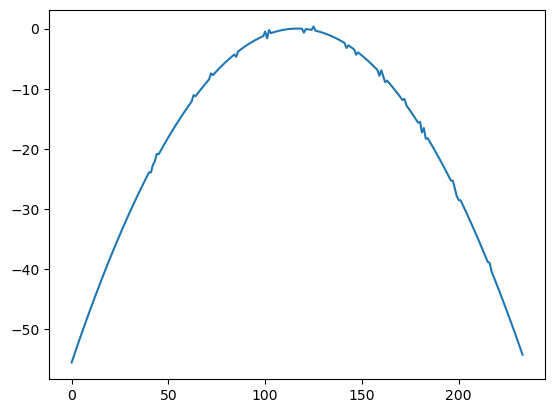

In [42]:
plt.plot(phase_array_now)

In [ ]:
C:\Users\KeckLFC\KeckLFC-main\KeckLFC\hispec_test\20240727_sapre_octave_waveguide_d2_m2p9_pwr_3p8.npz

In [30]:
delete_all_files_in_directory()

In [250]:
delete_all_files_in_directory()
phase_setting(wsp,x_hz,phase1)

score_spectrum(1800,2200)

2024-07-27 13:55:49.337 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-07-27 13:55:49.607 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\KeckLFC\\Desktop\\hispec\\data.txt'

In [47]:
phase_array_old=np.load(r'C:\Users\KeckLFC\KeckLFC-main\KeckLFC\hispec_test\20240727_sapre_octave_waveguide_d2_m2p9_pwr_3p8_origin.npz')['phase_array']
phase_setting(wsp,x_hz,phase_array_old)
delete_all_files_in_directory()
time.sleep(5)
save_data()
x,y=read_file()
y=np.log(y)

2024-08-18 09:15:15.117 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 09:15:16.305 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


In [50]:
phase_setting(wsp,x_hz,phase_array_now)
delete_all_files_in_directory()
time.sleep(5)
save_data()
x,y=read_file()
y=np.log(y)

2024-08-18 09:17:39.525 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:set_interp_phase:117
Waveshaper Set interp phase with center 192.17465256410256 THz.
2024-08-18 09:17:40.729 | INFO     | Finisar Waveshaper SN201904 | Waveshaper.py:writeProfile:235
Waveshaper profile write successful.


In [44]:
np.savez(r'C:\Users\KeckLFC\KeckLFC-main\KeckLFC\hispec_test\20240818_sapre_octave_waveguide_d2_m2p9_pwr_3p8_origin.npz',x=x,y=y,phase_array=phase_array_now)

In [228]:
delete_all_files_in_directory()

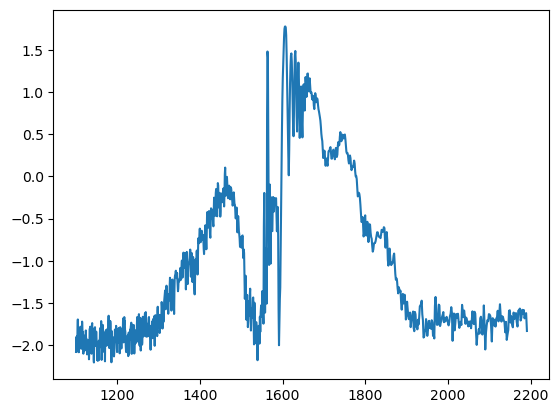

In [49]:
plt.plot(x,y)

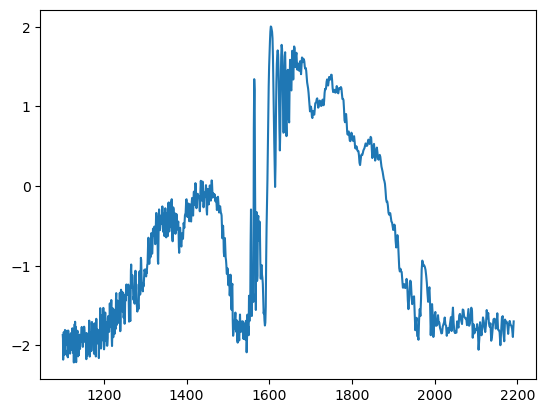

In [225]:
plt.plot(x,y)

## 2025 05 16
## only one test with yokogawa 6377

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time
import os

# 假设这个函数计算光谱的得分
def score_spectrum(osa,x,start_wl=1.6e-6,stop_wl=1.8e-6,hight_shreshold=None):
    time.sleep(0.03)
    osa.single()
    time.sleep(1)

    y=osa.get_Ydata('TRA')
    #x1=x[np.where((x>start_wl) & (x<stop_wl))] 
    y1=y[np.where((x>start_wl) & (x<stop_wl))]
    if hight_shreshold is None:
        hight_shreshold=-32
    peaks,_ = find_peaks(y1, height=hight_shreshold, distance=2, width=0.02e-9)
    num_peaks = len(peaks)

    score=np.sum(y1[peaks])+num_peaks*np.abs(hight_shreshold)*1.5
    return score

def optimize_d2(wsp,osa,x,d2_start=-6,d2_stop=-5.4,d2_step=0.01):

    d2_values= np.arange(d2_start,d2_stop,d2_step)
    scores = np.zeros((len(d2_values), 2))
    
    for i, d2 in enumerate(d2_values):

        wsp.set3rdDisper(d2,d3=0.)
        wsp.setBandPass(center=192.174,span=4)
        wsp.writeProfile()

        score = score_spectrum(osa,x)

        scores[i] = [d2, score]
        
        # 找到评分最高的d2
    max_index = np.argmax(scores[:, 1])
    best_d2 = scores[max_index, 0]
    best_score = scores[max_index, 1]

    return best_d2, best_score, scores


# 梯度下降算法
def optimize_phase(wsp,osa,x,x_hz,phase_array, step_size=0.1*2*np.pi, max_iterations=50, tolerance=1e-2, iterarion_start=0, i_start=0,
                   start_wl=1.6e-6,stop_wl=1.8e-6):
    
    phase_setting(wsp,x_hz,phase_array)
    
    best_score = score_spectrum(osa,x,start_wl,stop_wl)
    iteration = iterarion_start 
    i=i_start
    i_end=len(phase_array)-10
    try:
        while iteration < max_iterations:

            step_size = step_size / (1+iteration*0.6)

            while i < i_end:
                original_phase = phase_array[i]
                phase_array[i] = original_phase + 1 * step_size
                phase_setting(wsp,x_hz,phase_array)
                new_score = score_spectrum(osa,x,start_wl,stop_wl)
                if new_score > best_score:
                    best_score = new_score
                    print(f"Iteration {iteration}, Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score}")
                else:
                    phase_array[i] = original_phase - 1 * step_size
                    phase_setting(wsp,x_hz,phase_array)
                    new_score = score_spectrum(osa,x,start_wl,stop_wl)  
                    if new_score > best_score:
                        best_score = new_score
                    else:
                        phase_array[i] = original_phase
                    print(f"Iteration {iteration}, Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score}")
                i += 1
            i = 0
            iteration += 1
            if np.abs(new_score - best_score) < tolerance:
                break
        return phase_array, best_score, iteration, i
    
    except:
        return phase_array, best_score, iteration, i
    
def optimize_phase_single_step(wsp,osa,x,x_hz,phase_array, step_size=0.1*2*np.pi, i=0,
                     start_wl=1.6e-6,stop_wl=1.8e-6,score=0):
    best_score = score
    original_phase = phase_array[i]
    phase_array[i] = original_phase + 1 * step_size
    phase_setting(wsp,x_hz,phase_array)
    new_score = score_spectrum(osa,x,start_wl,stop_wl)
    if new_score > best_score+20:
        best_score = new_score

    else:
        phase_array[i] = original_phase - 1 * step_size
        phase_setting(wsp,x_hz,phase_array)
        new_score = score_spectrum(osa,x,start_wl,stop_wl)  
        if new_score > best_score+20:
            best_score = new_score
        else:
            phase_array[i] = original_phase
    print(f" Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score}")
    return phase_array, best_score, i

    
def optimize_phase_single_move(wsp,osa,x,x_hz,phase_array, step_size=0.1*2*np.pi, i=0,
                   start_wl=1.6e-6,stop_wl=1.8e-6,score=0):
    best_score = score
    original_phase = phase_array[i]
    new_score = np.zeros(7)
    move_yes=1
    phase_list=[original_phase + 1 * step_size, 
                original_phase + 0.5 * step_size, 
                original_phase + 0.25 * step_size,
                original_phase, 
                original_phase - 0.25 * step_size,
                original_phase - 0.5 * step_size,
                original_phase - 1 * step_size]
    
    for j in range(7):
        phase_array[i] = phase_list[j]
        phase_setting(wsp,x_hz,phase_array)
        new_score[j] = score_spectrum(osa,x,start_wl,stop_wl)

    phase_array[i] = phase_list[np.argmax(new_score)]
    if np.argmax(new_score) == 3:
        move_yes=0
    new_score_max = np.max(new_score)
    # if new_score_max > best_score:
    #     best_score = new_score_max
    #     phase_array[i] = phase_list[np.argmax(new_score)]
        
    # else:
    #     phase_array[i] = original_phase
    #     # phase_array[i] = original_phase - 1 * step_size
    #     # phase_setting(wsp,x_hz,phase_array)
    #     # new_score = score_spectrum(osa,x,start_wl,stop_wl)  
    #     # if new_score > best_score+90:
    #     #     best_score = new_score
    #     # else:
    #     #     phase_array[i] = original_phase
        
    print(f"Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score_max}, move yes {move_yes}") 
    return phase_array, new_score_max, i

def optimize_phase_group_move(wsp,osa,x,x_hz,phase_array, step_size=0.1*2*np.pi, i=0,
                     start_wl=1.6e-6,stop_wl=1.8e-6,score=0,gourp_num=1):
    
    best_score = score
    original_phase = np.copy(phase_array[i:i+gourp_num])
    new_score = np.zeros(7)

    move_yes=1

    phase_list=[original_phase + 1 * step_size,
                original_phase + 0.5 * step_size, 
                original_phase + 0.25 * step_size,
                original_phase, 
                original_phase - 0.25 * step_size,
                original_phase - 0.5 * step_size,
                original_phase - 1 * step_size]
    
    for j in range(7):
        phase_array[i:i+gourp_num] = phase_list[j]
        phase_setting(wsp,x_hz,phase_array)
        new_score[j] = score_spectrum(osa,x,start_wl,stop_wl)
    
    phase_array[i:i+gourp_num] = phase_list[np.argmax(new_score)]

    if np.argmax(new_score) == 3:
        move_yes=0

    new_score_max = np.max(new_score)

    print(f"Phase {i}, setp size {'%.4f' %step_size}, best score {'%.4f' %best_score},now score {'%.4f' %new_score_max}, move yes {move_yes}")
    return phase_array, new_score_max, i



def phase_setting(wsp,x_hz,y_phase):

    # x_nm=np.arange(1553,1567,0.06)
    # x_hz=wsp.nm2thz(x_nm)
    # #x_freq = np.linspace(192.175-2, 192.175+2, 100)
    # y_phase = ((x_hz-192.175) ** 2 * (2*np.pi) ** 2 * 1.3/2*-5.7)   #+ 0/((x_freq-192.3) ** 4 * (2*np.pi) ** 2 * 1.3/2+1)
    wsp.set_interp_phase(x_hz, y_phase)
    #wsp.setBandPass(center=192.174,span=4)
    #wsp.plotStatus()
    wsp.writeProfile(disable_beep=True)

def initial_phase_array(wsp,d2,start,stop,step):

    x_nm=np.arange(start,stop,step)
    x_hz=wsp.nm2thz(x_nm)
    #x_freq = np.linspace(192.175-2, 192.175+2, 100)
    y_phase = wsp.give_2ndDisp_phase(x_hz,d2)
    return x_hz,y_phase
    

def save_phase_array(phase_array, x,y,filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0'):

    filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0'

    np.savez(filename, phase_array=phase_array)

    np.savez(r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0', x=x, y=y)

# 示例使用
def initial_all_parameters():
    
    
    os.chdir(r'D:\astrocomb\KeckLFC-deploy')

    from Hardware.YOKOGAWAaq6375 import YOKOGAWAaq6375
    from Hardware.Waveshaper import Waveshaper
    osa = YOKOGAWAaq6375(addr='GPIB1::1::INSTR', name='Ando OSA AQ6315E')
    wsp = Waveshaper(addr='SN200157',WSname='Waveshaper')
    osa.connect()
    wsp.connect()

    d2= -5.7

    start_wl=1.6e-6
    stop_wl=1.8e-6

    osa.set_wavelength_start(start_wl)
    osa.set_wavelength_stop(stop_wl)
    osa.set_sample_points(4000)
    osa.set_resolution(0.05)
    osa.set_sensitivity('NORM')

    osa.single()
    x=osa.get_Xdata('TRA')
    # TRA not a!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    x_hz,y_phase = initial_phase_array(wsp,d2,1553,1567,0.06)

    
    phase_setting(wsp,x_hz,y_phase)



    return wsp,osa, x,x_hz, y_phase

In [300]:
from KeckLFC.Hardware.YOKOGAWAaq6375 import YOKOGAWAaq6375
osa = YOKOGAWAaq6375(addr='GPIB1::1::INSTR', name='Ando OSA AQ6315E')


In [378]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time
import os
def save_osa(x,y,filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0'):

    np.savez(filename, x=x, y=y)

In [387]:
osa.disconnect()

0

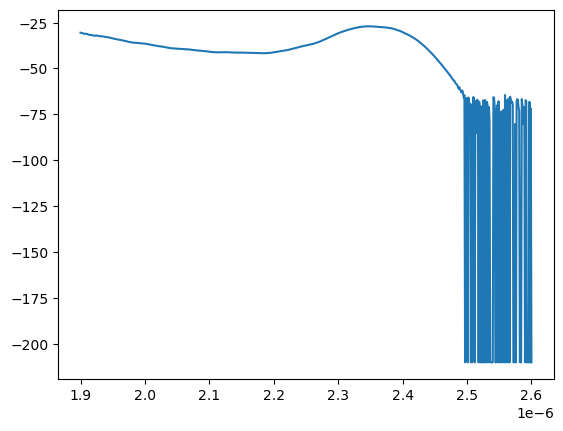

In [383]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import time
import os
def save_osa(x,y,filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0'):

    np.savez(filename, x=x, y=y)

xx,yy = osa.get_trace('TRA')

plt.plot(xx,yy)

save_osa(xx,yy,filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\2m_pm_3m_hlnf_4w')

In [377]:
def save_osa(x,y,filename=r'C:\Users\KeckLFC\Desktop\hispec\osamidir\0'):

    np.savez(filename, x=x, y=y)